# Laboratorio 1

In [402]:
#Instalcion de todas las librerias
import pandas as pd
import numpy as np
import sys
from joblib import dump, load
import scipy.stats as stats
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


### Carga de datos

In [403]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('train_data.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos

Mostrando que los datos se cargan

In [404]:
data

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1237648720690741273,172.826005,-0.484303,18.81890,17.89273,17.54372,17.41363,17.31821,756,2,381,0.887803,1,STAR,1.521540e-04,54891,0.000675,0.000324
3996,1237649918427267086,11.165126,13.745240,17.46665,15.96142,15.36014,15.14572,15.04453,1035,1,38,0.844826,1,STAR,4.182837e-05,53242,-0.000440,-0.000301
3997,1237648720164684046,197.579529,-0.971573,19.45682,18.32555,17.86916,17.57512,17.41648,756,1,546,0.819151,1,GALAXY,8.160563e-02,51985,0.011348,0.005854
3998,1237648721206575779,124.877626,-0.048110,19.20158,17.31450,16.36573,15.91760,15.57736,756,3,60,0.894044,1,GALAXY,8.744828e-02,55888,-0.004486,-0.006072


## Entendimiento de los Datos

Antes de comenzar a analizar los datos, es fundamental identificar que datos son más importantes que otros, para nuestro fin que es buscar el RedShift. El cual describe cómo la luz de un objeto astronómico se desplaza hacia longitudes de onda más largas debido a la expansión del universo. Su correcta estimación nos permite calcular distancias cósmicas y estudiar la evolución del universo. Por esta razón, priorizamos aquellas variables que pueden influir directamente en su cálculo y descartamos aquellas que no aportan información significativa.

###  Variables Necesarias

- **ra**
  - Ubicación del objeto en su componente de ascensión recta de coordenada celeste.
  - Es importante para referenciar la ubicación del objeto y en algunos modelos avanzados puede aportar información contextual relevante.
- **dec**
  - Ubicación del objeto en su componente de declinación de coordenada celeste.
  - Permite ubicar correctamente el objeto en la esfera celeste y, junto con ra, es clave para contextualizar observaciones.
- **u, g, r, z, i (Magnitudes en diferentes filtros)**
  - Permiten clasificar y caracterizar los objetos en función de su emisión de luz en distintos rangos de longitud de onda.
  - Son fundamentales para estimar redshifts fotométricos si se quiere hacer una estimación sin espectroscopía.
- **class**
  - Indica si el objeto es una estrella (**STAR**), una galaxia (**GALAXY**) o un cuásar (**QSO**). 
  - Es relevante porque el redshift se aplica mayormente a galaxias y cuásares, mientras que las estrellas cercanas no presentan redshifts significativos.
- **redshift**
  - Es el valor clave de estudio, ya que representa el corrimiento al rojo del objeto.

###  Variables no necesarias
Las siguientes variables fueron descartadas por su baja relevancia en la estimación del redshift o porque su información ya está implícitamente contenida en otras variables:

- **mjd**
  - Día juliano en que se registró el objeto.
  - Puede ser útil si se estudian variaciones en observaciones a lo largo del tiempo, pero en nuestro caso no la tomamos en cuenta, ya que es un analisis estatico.
- **run**
  - Es la cantidad de observaciones realizadas por el telescopio pero en este caso no es importante
- **camcol**
  - Dado que es un atributo técnico de la instrumentación y no del objeto en sí, se considera irrelevante para el modelo.
  - Columna de la cámara en la que se registró el objeto. Se reviso la correlacion lineal pero fue muy bajo tambien por eso se descarto esto.     
 - **field**
    - Sección de la columna de la cámara en la que se registró el objeto. Ya que Camcol no la tomamos importante esta tampoco para el analisis      
- **score**
  - Indica la calidad de la observación. Es  útil para filtrar datos de baja calidad.
- **clean**
  - También puede ayudar a filtrar observaciones con problemas en la fotometría, lo usamos para eliminar datos ya que junto con Run nos da informacion.
- **rowv**
  - Velocidad horizontal (fila) del objeto en grados/día.
- **colv**
  - Velocidad vertical (columna) del objeto en grados/columna..




## Visualización de datos

array([[<Axes: title={'center': 'objid'}>,
        <Axes: title={'center': 'ra'}>, <Axes: title={'center': 'dec'}>,
        <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'r'}>,
        <Axes: title={'center': 'i'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'run'}>,
        <Axes: title={'center': 'camcol'}>,
        <Axes: title={'center': 'field'}>,
        <Axes: title={'center': 'score'}>],
       [<Axes: title={'center': 'clean'}>,
        <Axes: title={'center': 'redshift'}>,
        <Axes: title={'center': 'mjd'}>,
        <Axes: title={'center': 'rowv'}>],
       [<Axes: title={'center': 'colv'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

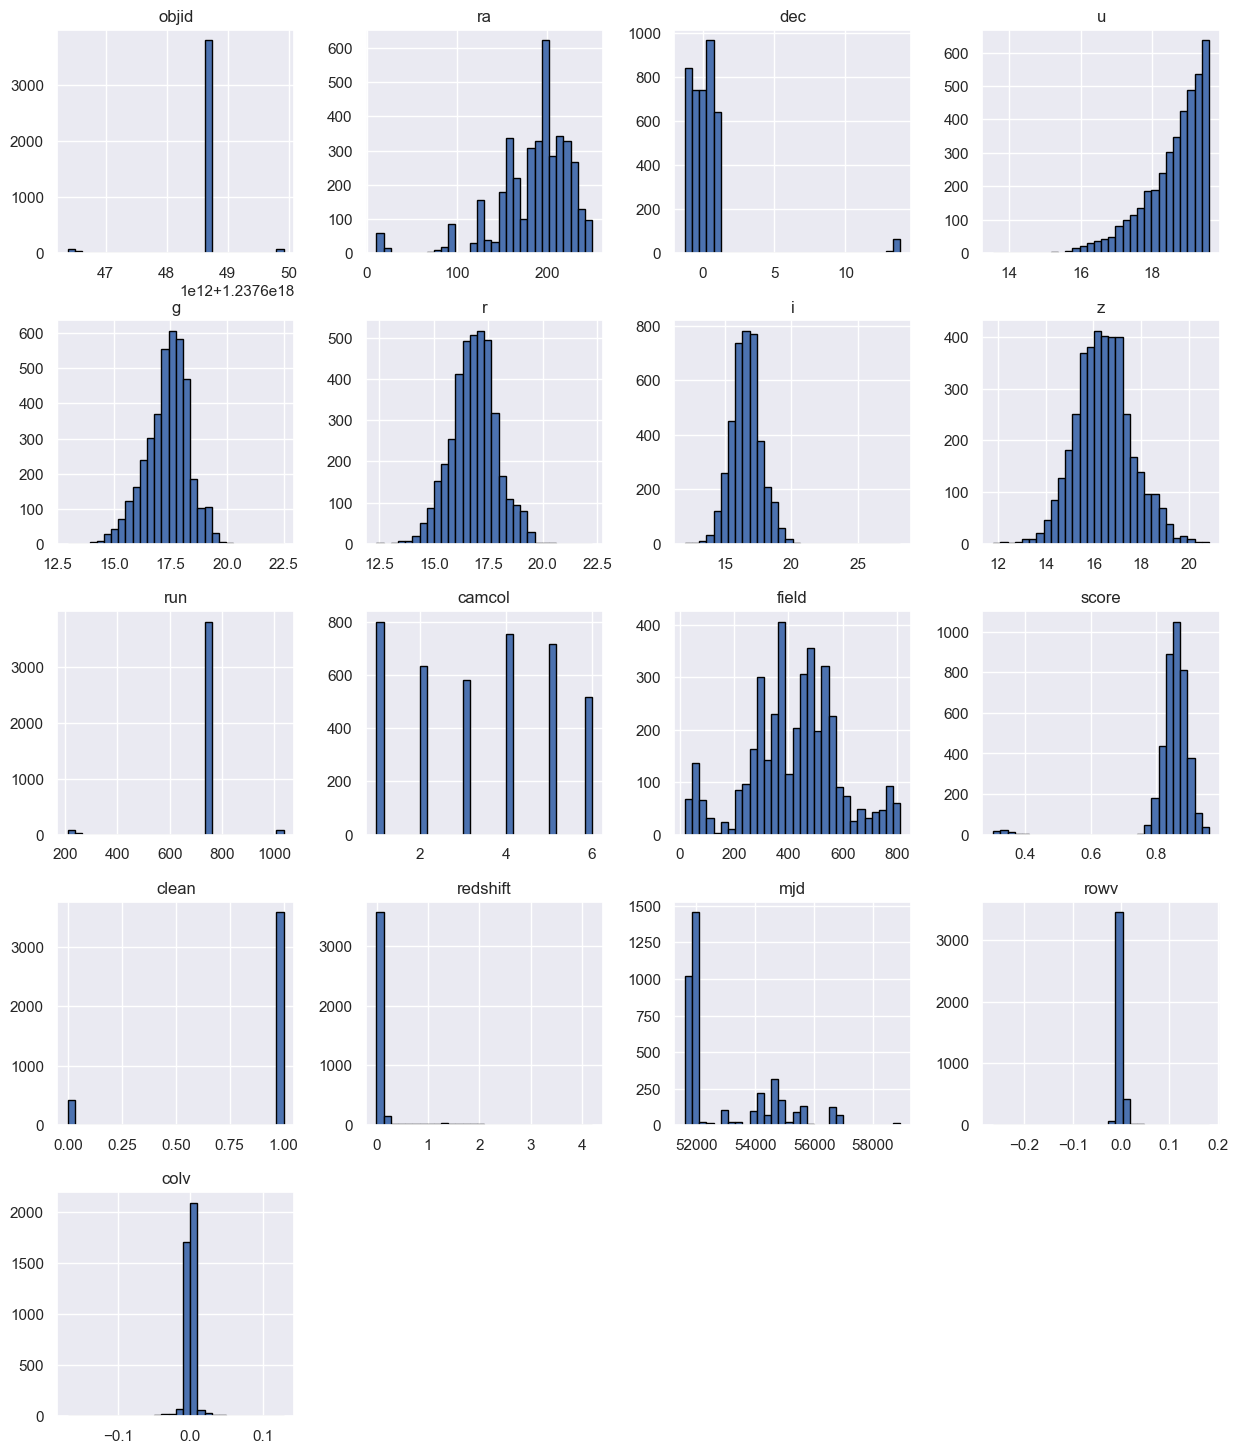

In [405]:
data.hist(figsize=(15,18),bins=30,edgecolor="black")

In [406]:
#Entendimiento del tamaño del data Set a ser manejado
print('Dimensiones de los datos: ', data.shape, 'El primer valor corresponde a filas y el segundo a columnas')

Dimensiones de los datos:  (4000, 18) El primer valor corresponde a filas y el segundo a columnas


In [407]:
# Visualizacion de los primeros 10 datos
display(data.head(10))

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
5,1237648720132178408,123.386052,-1.045499,18.52214,17.45173,17.23112,17.16427,17.13214,756,1,50,0.851417,1,STAR,1.190440e-05,53816,-0.002165,-0.000364
6,1237648720165863598,200.243728,-0.895931,18.09523,16.82764,16.18942,15.83503,15.58671,756,1,564,0.815295,0,GALAXY,4.815651e-02,51984,-0.011610,0.002361
7,1237648704054624442,216.256661,-0.220799,19.20765,18.73173,18.84302,18.98353,19.15128,752,3,486,0.804086,1,STAR,-2.234210e-04,51613,-0.002153,-0.001026
8,1237648722308890870,190.050847,0.695672,17.82951,15.90091,15.02515,14.61881,14.30353,756,5,496,0.822898,1,GALAXY,4.634102e-02,51941,-0.000474,-0.001548
9,1237648720163963081,195.951990,-0.966005,17.76132,16.51327,15.89811,15.53069,15.31236,756,1,535,0.811336,1,GALAXY,8.944633e-02,51986,0.000894,0.001024


In [408]:
# Imprimimos los diferentes tipos de las columnas
data.dtypes

objid         int64
ra          float64
dec         float64
u           float64
g           float64
r           float64
i           float64
z           float64
run           int64
camcol        int64
field         int64
score       float64
clean         int64
class        object
redshift    float64
mjd           int64
rowv        float64
colv        float64
dtype: object

In [409]:
# Imprimir las columnas numericas
columnasNumericas= data.select_dtypes(include=['int','float']).columns
print(columnasNumericas)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field',
       'score', 'clean', 'redshift', 'mjd', 'rowv', 'colv'],
      dtype='object')


In [410]:
data.describe( include='all')

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
count,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000,4000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GALAXY,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1857,NaN,NaN,NaN,NaN
mean,1.237649e+18,185.523295,0.248959,18.609049,17.363397,16.839856,16.597712,16.439392,743.829000,3.37625,419.602000,0.851765,0.895500,NaN,0.134015,52957.124750,0.000218,-0.000090
std,4.244222e+11,41.689446,2.001075,0.839431,0.950964,1.055343,1.141252,1.190502,98.865936,1.69909,167.162063,0.071311,0.305946,NaN,0.379742,1601.148131,0.008794,0.007457
min,1.237646e+18,10.469743,-1.252763,13.551780,12.974870,12.362850,12.010790,11.799530,211.000000,1.00000,19.000000,0.301912,0.000000,NaN,-0.003322,51608.000000,-0.264516,-0.168807
25%,1.237649e+18,162.474666,-0.631824,18.170375,16.796110,16.190785,15.870782,15.628205,752.000000,2.00000,311.000000,0.836866,1.000000,NaN,0.000106,51821.000000,-0.001212,-0.001609
50%,1.237649e+18,195.815451,0.053336,18.843745,17.472525,16.850835,16.571195,16.402665,756.000000,3.00000,434.000000,0.860675,1.000000,NaN,0.032038,51986.000000,0.000322,0.000125
75%,1.237649e+18,214.348425,0.593396,19.261563,17.997818,17.506640,17.258833,17.147037,756.000000,5.00000,527.000000,0.879834,1.000000,NaN,0.086479,54468.000000,0.001698,0.001672


### Analisis de la calidad de los datos

##### Completitud

In [411]:
data.isnull().sum()
data.isna().sum()

objid       0
ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
run         0
camcol      0
field       0
score       0
clean       0
class       0
redshift    0
mjd         0
rowv        0
colv        0
dtype: int64

Al hacer un examen de completitud de los datos podemos ver que no hay datos nulos en ninguna columna del data frame

##### Unicidad

In [412]:
duplicados = data[data.duplicated()]

duplicados_todos = data[data.duplicated(keep=False)]

num_duplicados = data.duplicated().sum()

print(f"Total de filas duplicadas: {data.duplicated().sum()}")
print(duplicados_todos)


Total de filas duplicadas: 17
                    objid          ra       dec         u         g         r  \
88    1237648703513428079  206.374167 -0.781673  18.28101  17.18856  16.70175   
109   1237648721231609897  182.015940 -0.116600  17.96686  16.91550  16.75447   
114   1237646382079606869   94.679499  0.842321  18.47695  16.94897  16.68126   
299   1237648721756225804  154.036159  0.417930  19.50457  18.08980  17.29931   
629   1237648720687988788  166.623017 -0.546630  19.55528  17.73928  16.86703   
642   1237648720715710772  229.932143 -0.607750  18.34448  17.39741  17.08713   
718   1237648721789780467  230.664376  0.229439  19.48961  18.21590  17.50523   
719   1237648721788993889  228.864817  0.317359  18.88618  17.66549  17.09694   
856   1237648705679065271  247.896821  0.990909  16.74659  15.61752  15.43460   
897   1237646382079672642   94.883887  0.990686  17.03847  15.47224  15.10297   
1231  1237648720163832016  195.688105 -0.868582  19.20444  18.01077  17.32575  

Podemos ver que si hay filas duplicadas por tanto se eliminarn las 17 filas que se encuentran duplicadas

In [413]:
data = data.drop_duplicates()
print("Data duplicada eliminada, hacemos verificacion",{data.duplicated().sum()})

Data duplicada eliminada, hacemos verificacion {0}


##### Consistencia

In [414]:
data['ra'].value_counts()

ra
185.574486    1
189.234768    1
147.394044    1
161.558526    1
170.899310    1
             ..
187.643235    1
153.656882    1
153.327761    1
123.194360    1
190.920230    1
Name: count, Length: 3983, dtype: int64

## 🔍 Análisis Detallado Columna

Para garantizar la calidad de los datos, realizaremos un análisis más detallado en cada columna, asegurándonos de que cumplan con los siguientes criterios:
  * Completitud
  * Duplicidad
  * Consistencia
  * Estandarización
---
## 📊 Visualización
Utilizaremos gráficos y estadísticas descriptivas para analizar la distribución de los datos y detectar posibles anomalías.


## Columna 'ra'
Describe: Ubicación del objeto en su componente de ascensión recta de coordenada celeste.

In [415]:
data['ra'].describe()

count    3983.000000
mean      185.492078
std        41.675011
min        10.469743
25%       162.463210
50%       195.804913
75%       214.315696
max       249.758313
Name: ra, dtype: float64

In [416]:
#Revisar si hay datos Nulos en la columna ra
data['ra'].isna().sum()

0

In [417]:
# Ya que Ra describe la ubicación del objeto en su componente de ascensión recta de coordenada celeste. Este valor debe de estar entre 0 y 360 grados.
df_out_rango = data[(data["ra"] < 0) | (data["ra"] > 360)]
print(df_out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


162.4632096 214.31569555 51.85248594999999
84.68448067500002 292.094424475


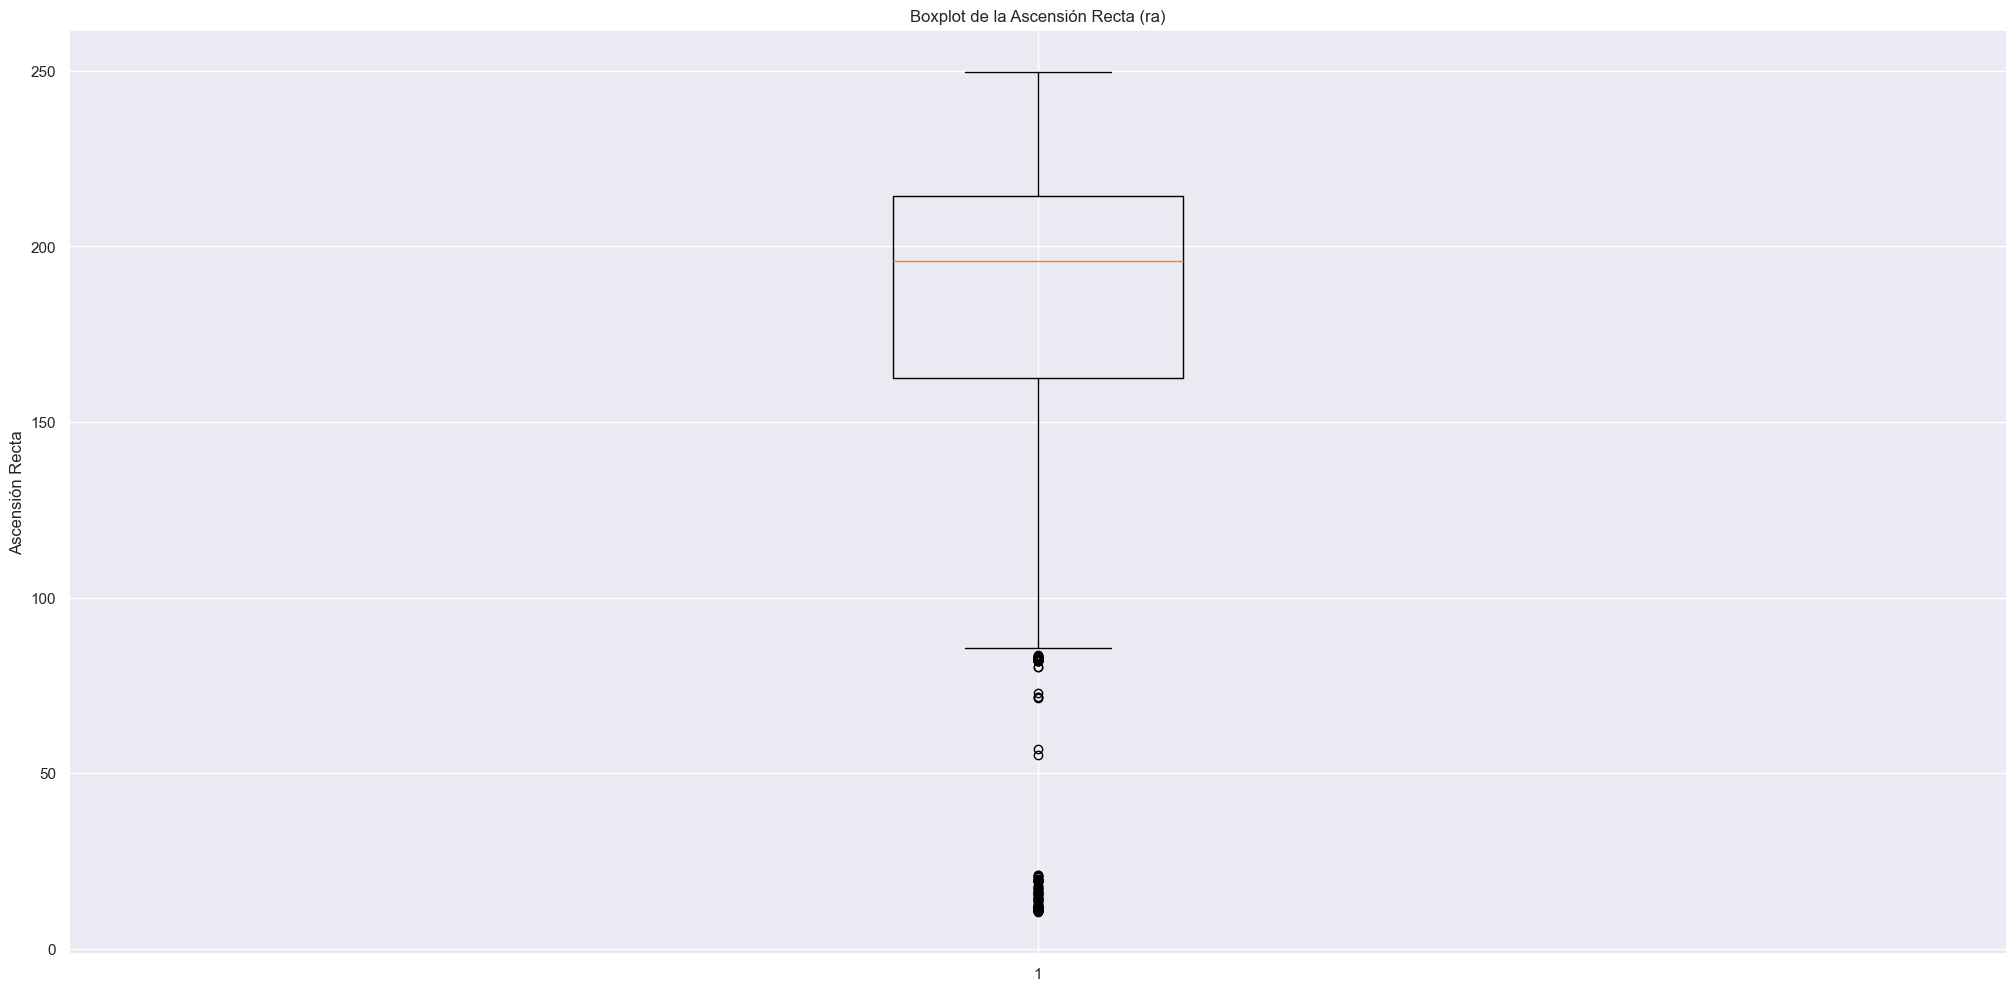

In [418]:
#Revisamos si se encuentra dentro del rango intercuartil, los valores que se encuentren por fuera de esto son outlayers [Q1−1.5×IQR,Q3+1.5×IQR]

Q1 = data['ra'].quantile(0.25)
Q3 = data['ra'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['ra'] < lower_bound) | (data['ra'] > upper_bound)]
# print(outliers['ra'])
outliers
plt.boxplot(data['ra'])
plt.title("Boxplot de la Ascensión Recta (ra)")
plt.ylabel("Ascensión Recta")
plt.show()

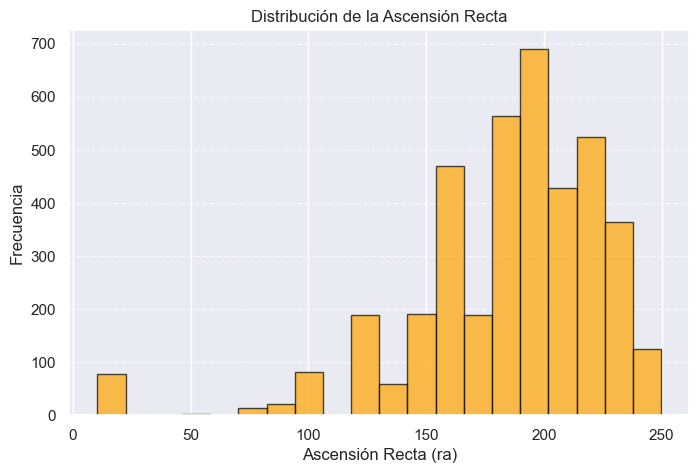

In [419]:
# Crear el histograma para visualizar la distribución de 'ra'
plt.figure(figsize=(8, 5))
plt.hist(data["ra"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (ra)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### 📊 Análisis de la Distribución de Datos de ra

####  Distribución General:
- La mediana(línea naranja) se encuentra cerca del centro del cajón, lo que indica que la distribución no está demasiado sesgada.
- La mayoría de los datos se encuentran en el rango intercuartil (IQR), es decir, entre el primer y tercer cuartil.

---

####  Valores Atípicos (Outliers):
- Se observan varios **outliers** en la parte inferior, lo que sugiere que existen valores **significativamente bajos** de ascensión recta en comparación con la mayoría de los datos.
- Sin embargo estan dentro del rango de valores que puede tener el ra.

## Columna dec
Describe: Ubicación del objeto en su componente de declinación de coordenada celeste.

In [420]:
data['dec'].describe()

count    3983.000000
mean        0.249842
std         2.004738
min        -1.252763
25%        -0.631846
50%         0.052999
75%         0.593016
max        13.854010
Name: dec, dtype: float64

Ya que los datos son muy pequeños entramos en dudas de la metrica de dec si esta en grados o radianes por tanto hizimos la conversion a radianes para revisar sus limites

In [421]:
data.loc[:, "dec_radianes"] = np.radians(data["dec"])  # Convierte grados a radianes

/var/folders/1j/z75cknhx76s2v56sd6b61_5w0000gn/T/ipykernel_55035/813652435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "dec_radianes"] = np.radians(data["dec"])  # Convierte grados a radianes


In [422]:
data['dec_radianes'].describe()


count    3983.000000
mean        0.004361
std         0.034989
min        -0.021865
25%        -0.011028
50%         0.000925
75%         0.010350
max         0.241798
Name: dec_radianes, dtype: float64

In [423]:
lower_bound = np.radians(-90)  # -π/2
upper_bound = np.radians(90)   # π/2
print(lower_bound,upper_bound)

-1.5707963267948966 1.5707963267948966


Ya que los datos si estan entre los rangos de radianes podemos concluir que los iniciales si estaban en grados por tanto los manejaremos en grados

Ya que Dec describe la ubicación del objeto en su componente de declinación de coordenada celeste. Este valor debe de estar entre -90 y 90 grados.

In [424]:
outlayer = data[(data["dec"] < -90) | (data["dec"] > 90)]
print(outlayer)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv, dec_radianes]
Index: []


-0.63184566 0.5930160025 1.2248616625
-2.46913815375 2.43030849625


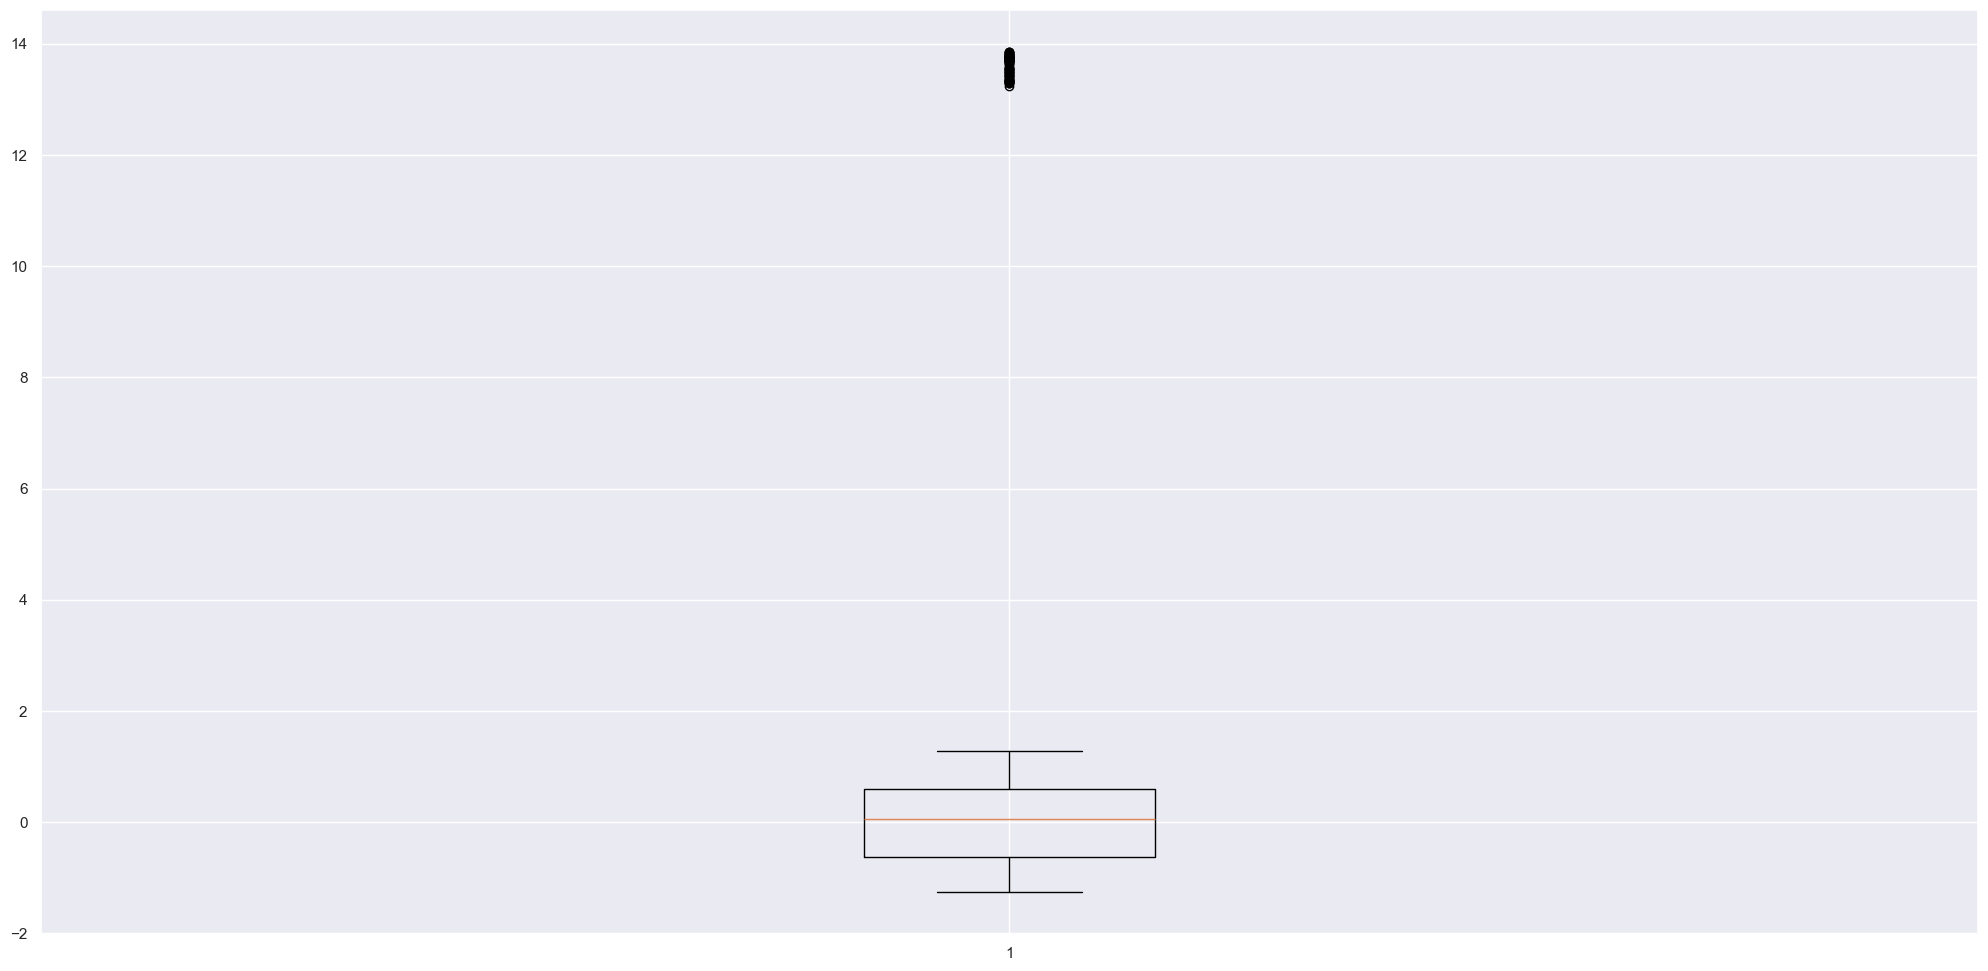

In [425]:
Q1 = data['dec'].quantile(0.25)
Q3 = data['dec'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['dec'] < lower_bound) | (data['dec'] > upper_bound)]
# print(outliers['dec'])
outliers
plt.boxplot(data['dec'])
plt.show()


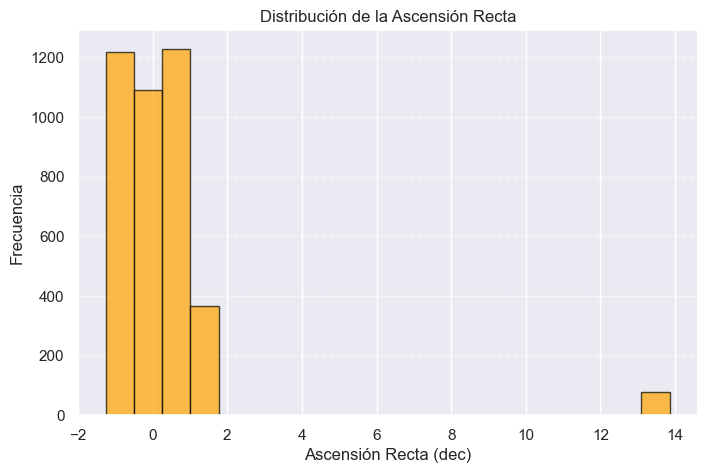

In [426]:
plt.figure(figsize=(8, 5))
plt.hist(data["dec"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (dec)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

#### Vamos a revisar ese dato que se sale lejos de los demas

In [427]:
# Vamos a eliminar esos valores que estan lejos de los normales con el argumento de que tiene una fotometria que no es confiable dado a que esta ne 0
outliers2 = data[(data["clean"] == 0) & (data["dec"] > 10)]
print(f"Número de filas a eliminar: {len(outliers2)}")
data = data[~((data["clean"] == 0) & (data["dec"] > 10))]
print(f"Número de filas después de la limpieza: {len(data)}")

Número de filas a eliminar: 8
Número de filas después de la limpieza: 3975


## Columna U
Magnitud del objeto capturada en el filtro ultravioleta. Valor mayor a 0.

In [428]:
data['u'].describe()

count    3975.000000
mean       18.609336
std         0.839123
min        13.551780
25%        18.170765
50%        18.843730
75%        19.261455
max        19.599750
Name: u, dtype: float64

In [429]:
# Revisamos si es que existen valores por debajo del 0 
outliers = data[(data['u'] <= 0)]
outliers

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv,dec_radianes


In [430]:
# Revisamos si es que existen valores por encima de 30, ya que normalmente, las magnitudes de objetos astronómicos en el filtro ultravioleta están en un rango entre 0 y 30
outliers = data[(data['u'] > 30)]
outliers

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv,dec_radianes


18.170765000000003 19.261454999999998 1.090689999999995
16.53473000000001 20.89748999999999


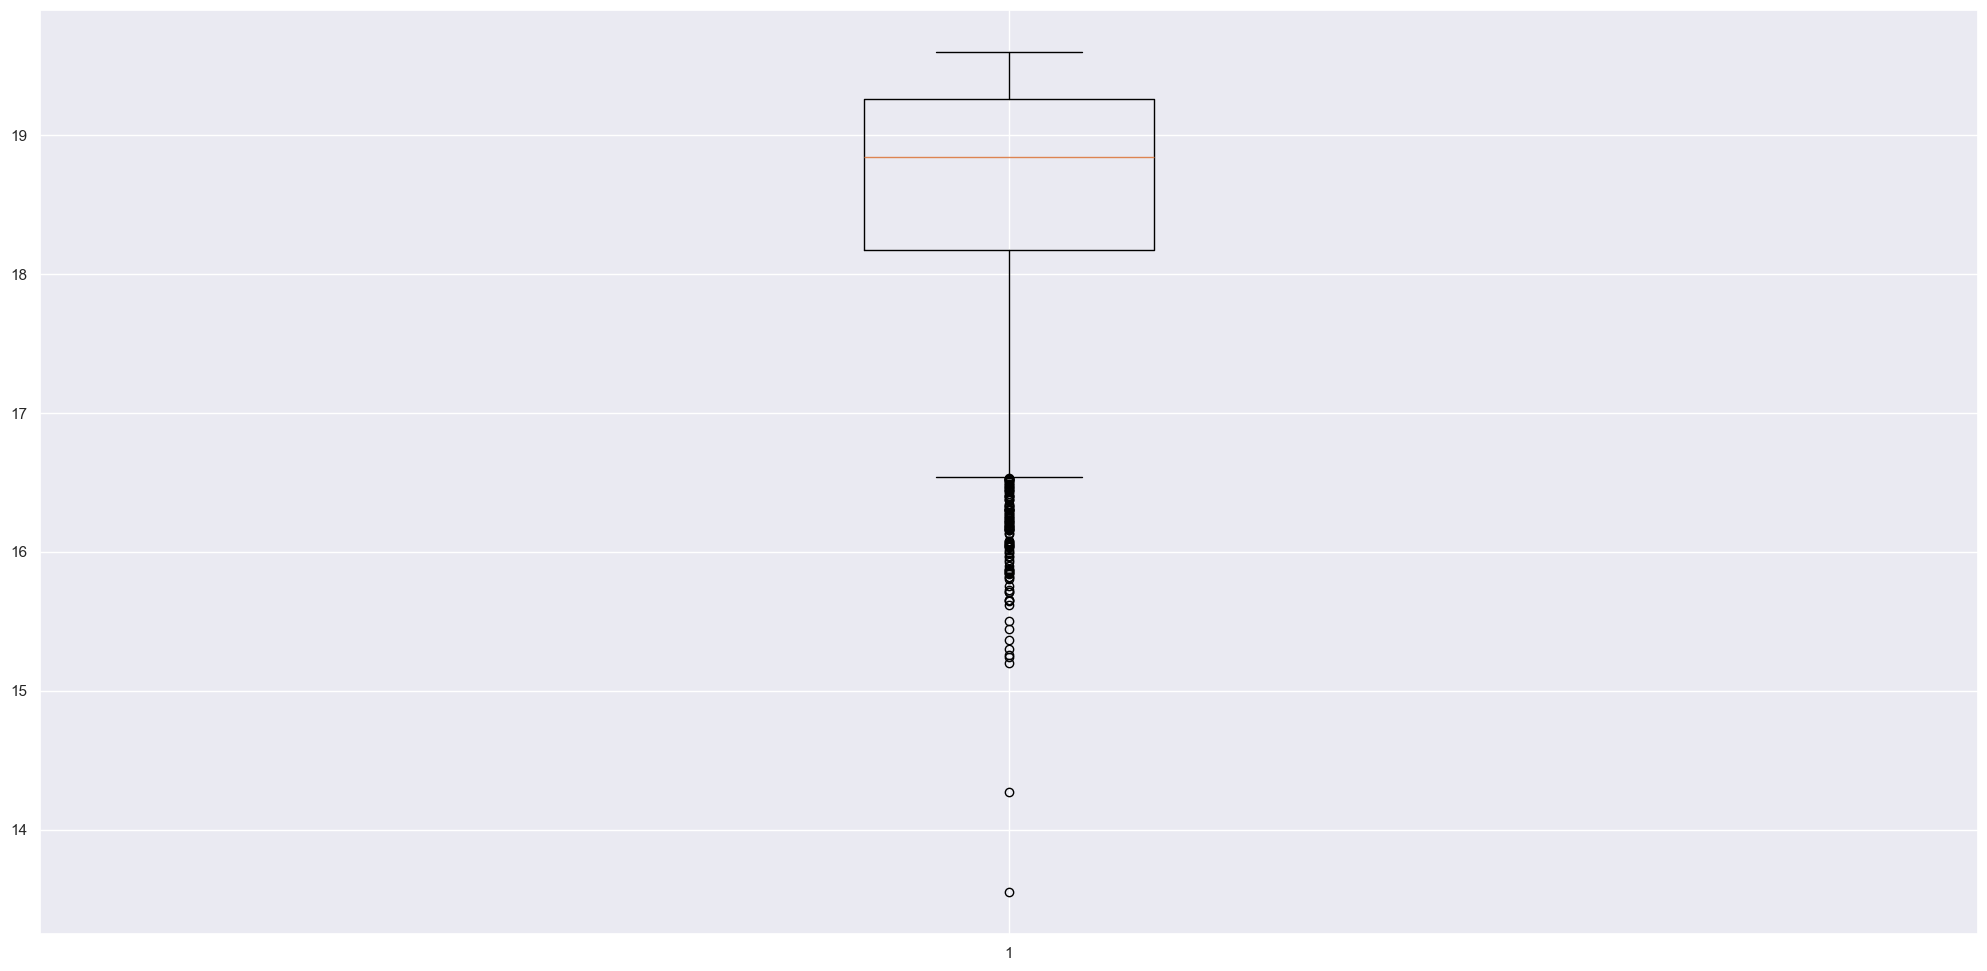

In [431]:
Q1 = data['u'].quantile(0.25)
Q3 = data['u'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['u'] < lower_bound) | (data['u'] > upper_bound)]
# print(outliers['dec'])
outliers
plt.boxplot(data['u'])
plt.show()


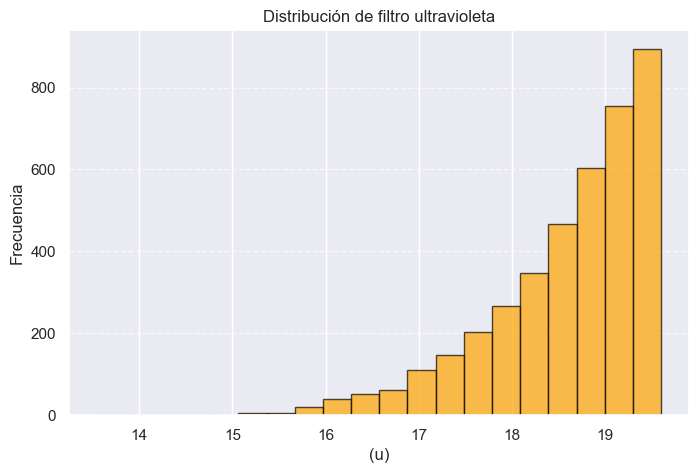

In [432]:
plt.figure(figsize=(8, 5))
plt.hist(data["u"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("(u)")
plt.ylabel("Frecuencia")
plt.title("Distribución de filtro ultravioleta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [433]:
data = data[~(data["clean"] == 0) & (data["u"] < 16) & data["score"]<0.4]
print(f"Número de filas a eliminar: {len(outliers2)}")

corr, p_value = stats.pearsonr(data["u"], data["redshift"])
print(f"Correlación: {corr}, p-valor: {p_value}")


Número de filas a eliminar: 8
Correlación: 0.16725371560267285, p-valor: 3.8370196443926414e-26


Elimino los datos que tienen poco score y su imagen esta sucia, pero que respeta los datos de u que estan alejados

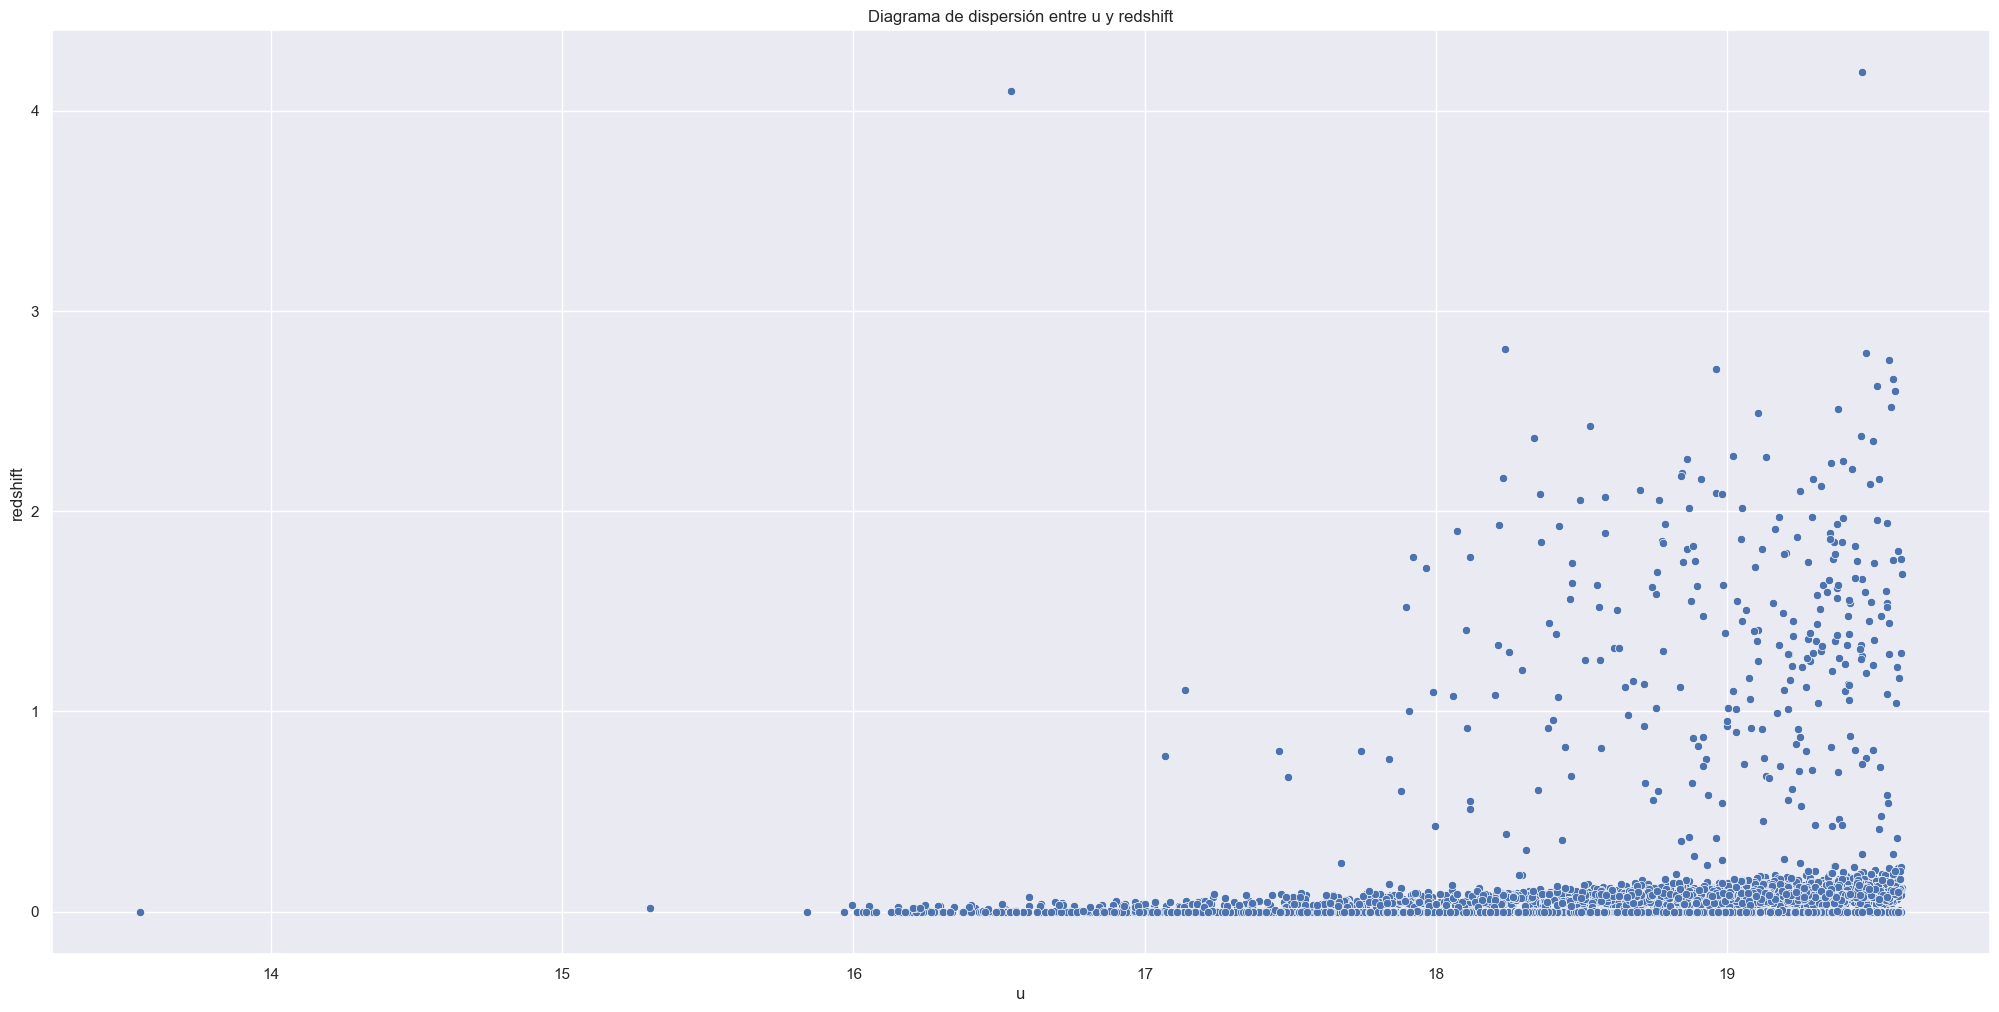

In [434]:
sns.scatterplot(x=data["u"], y=data["redshift"])
plt.title("Diagrama de dispersión entre u y redshift")
plt.show()

## Columna g
Describe: Ubicación del objeto en su componente de declinación de coordenada celeste.

In [435]:
data['g'].describe()

count    3945.000000
mean       17.384773
std         0.921690
min        14.116780
25%        16.824030
50%        17.478810
75%        18.001600
max        22.497450
Name: g, dtype: float64

In [436]:
#Ya que g describe la magnitud del objeto en el filtro verde este va entre 12-25
out_rango = data[(data["g"] > 25) | (data["g"] < 12)]
print(out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv, dec_radianes]
Index: []


In [437]:
menor0 = data[(data["g"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv, dec_radianes]
Index: []


16.82403 18.0016 1.1775699999999993
15.057675000000001 19.767955


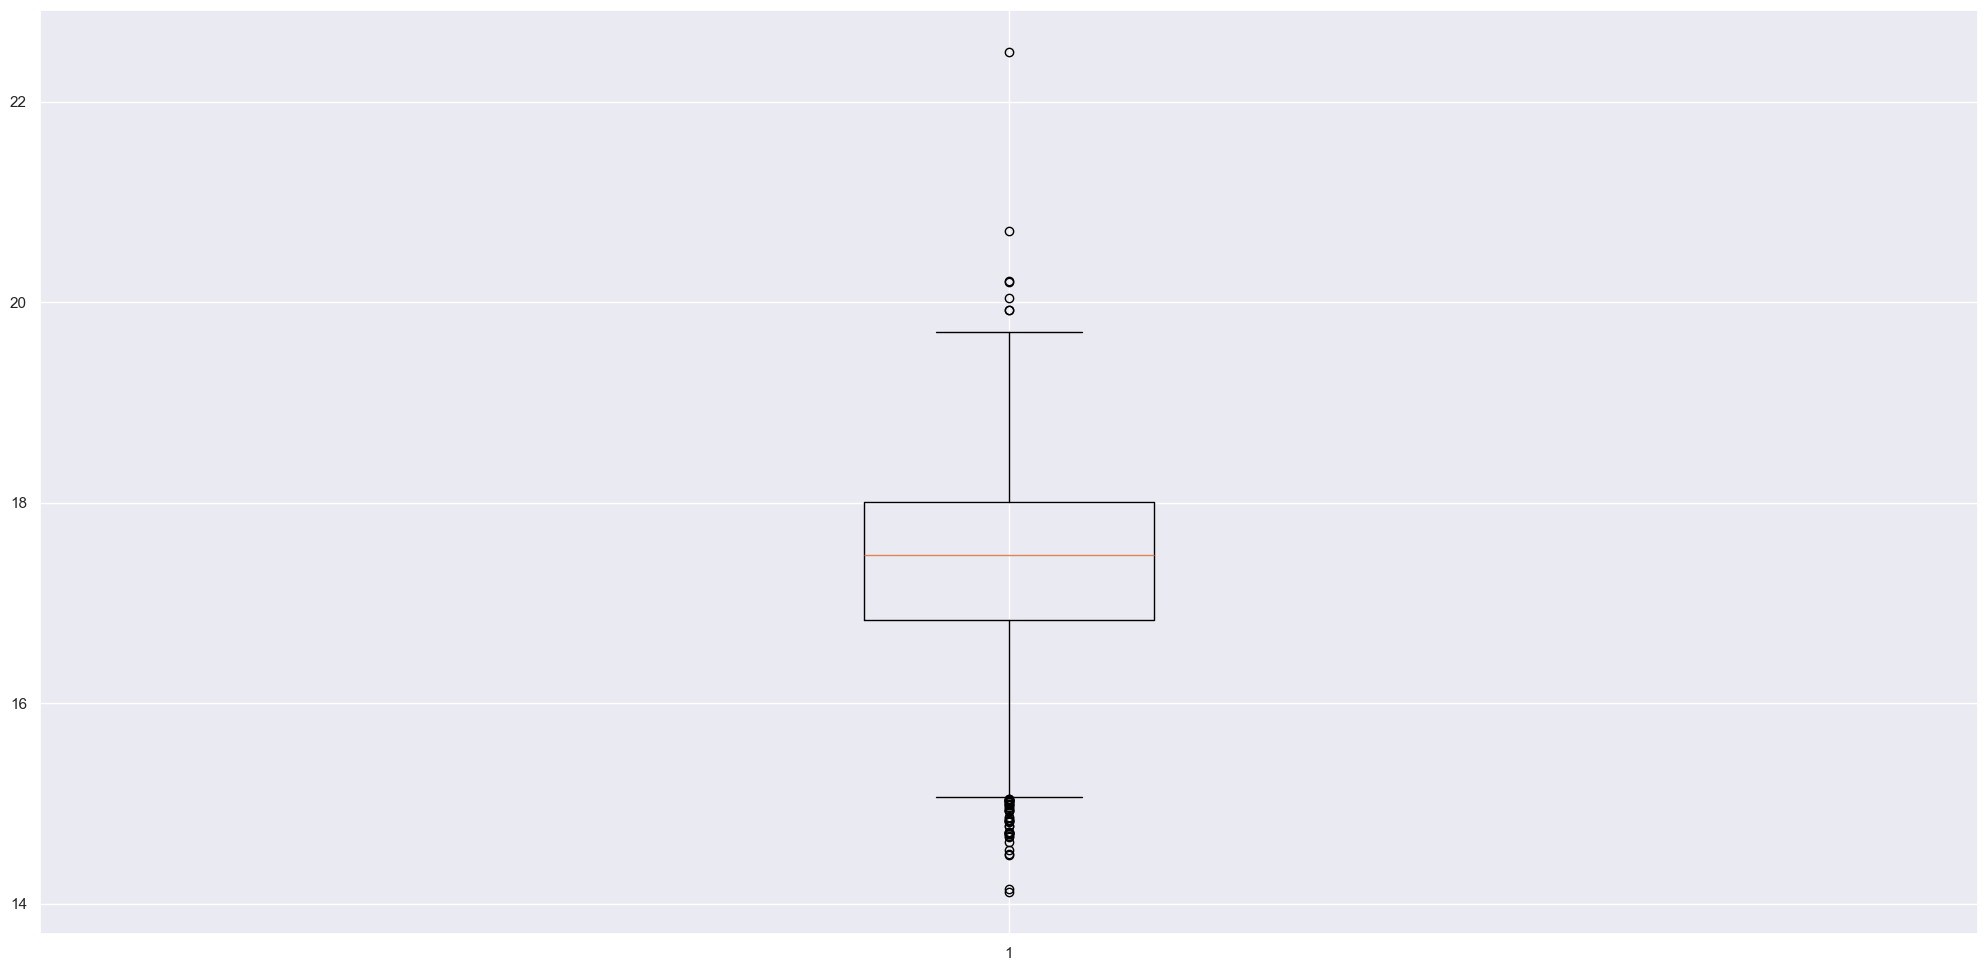

In [438]:
Q1 = data['g'].quantile(0.25)
Q3 = data['g'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['g'] < lower_bound) | (data['g'] > upper_bound)]
# print(outliers['dec'])
outliers
plt.boxplot(data['g'])
plt.show()


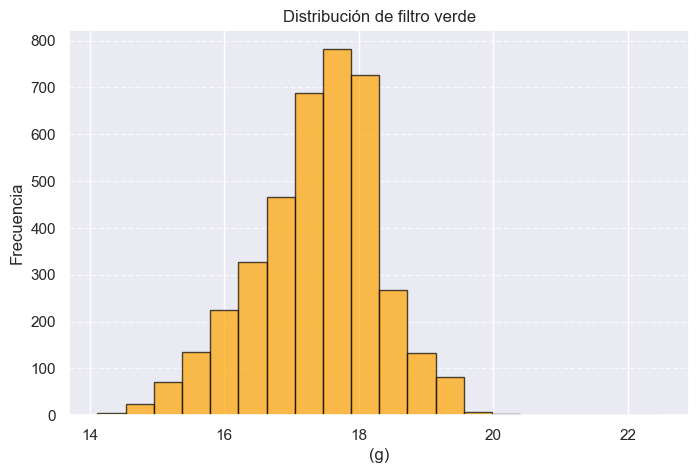

In [439]:
plt.figure(figsize=(8, 5))
plt.hist(data["g"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("(g)")
plt.ylabel("Frecuencia")
plt.title("Distribución de filtro verde")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna r
Describe: Magnitud del objeto capturada en el filtro rojo. Valor mayor a 0.

In [440]:
data['r'].describe()

count    3945.000000
mean       16.859738
std         1.032275
min        13.253640
25%        16.205540
50%        16.859250
75%        17.511880
max        22.265960
Name: r, dtype: float64

In [441]:
menor0 = data[(data["r"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv, dec_radianes]
Index: []


16.20554 17.51188 1.3063400000000023
14.246029999999996 19.471390000000007


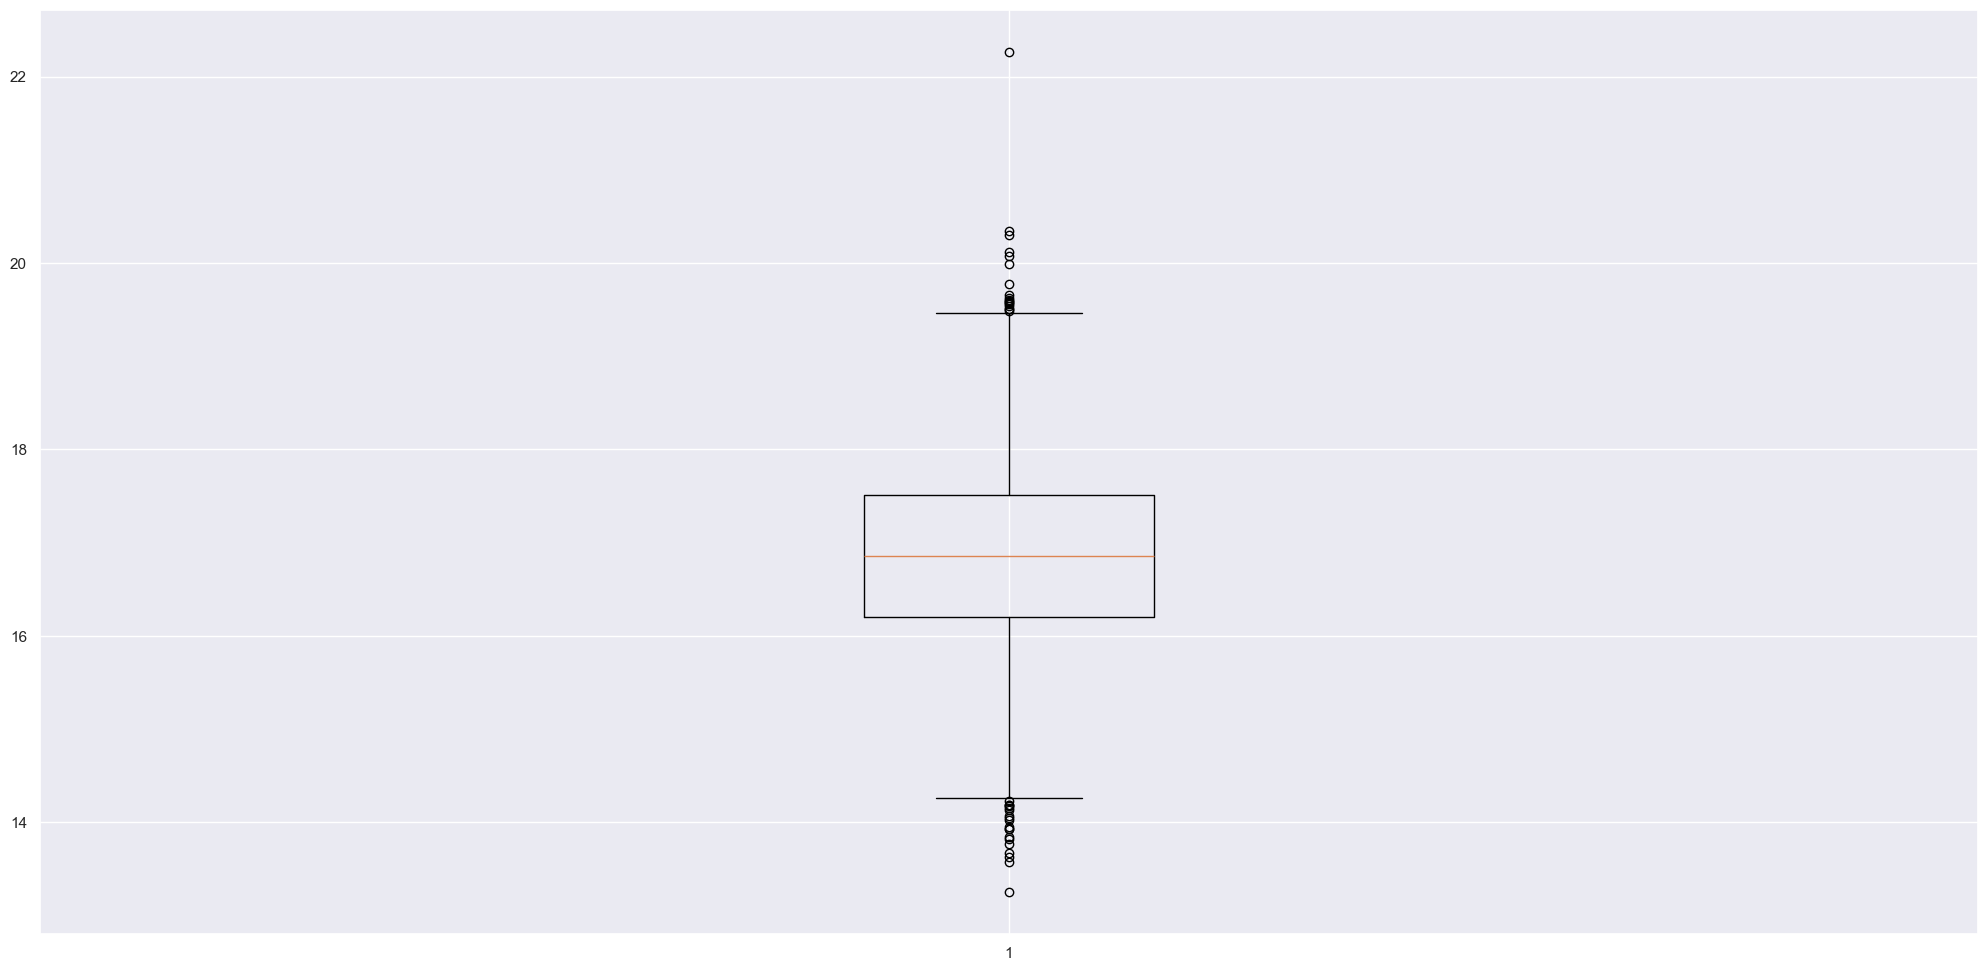

In [442]:
Q1 = data['r'].quantile(0.25)
Q3 = data['r'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['r'] < lower_bound) | (data['r'] > upper_bound)]
# print(outliers['g'])
outliers
plt.boxplot(data['r'])
plt.show()

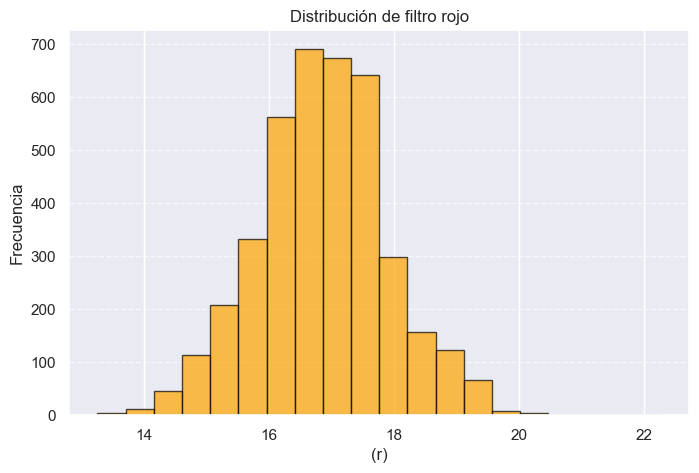

In [443]:
plt.figure(figsize=(8, 5))
plt.hist(data["r"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("(r)")
plt.ylabel("Frecuencia")
plt.title("Distribución de filtro rojo")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna z
Describe: Magnitud del objeto capturada en el filtro casi-infrarrojo. Valor mayor a 0.

In [444]:
data['z'].describe()

count    3945.000000
mean       16.457291
std         1.173335
min        12.558240
25%        15.643340
50%        16.410430
75%        17.153980
max        20.847690
Name: z, dtype: float64

In [445]:
menor0 = data[(data["z"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv, dec_radianes]
Index: []


15.64334 17.15398 1.5106400000000004
13.377379999999999 19.41994


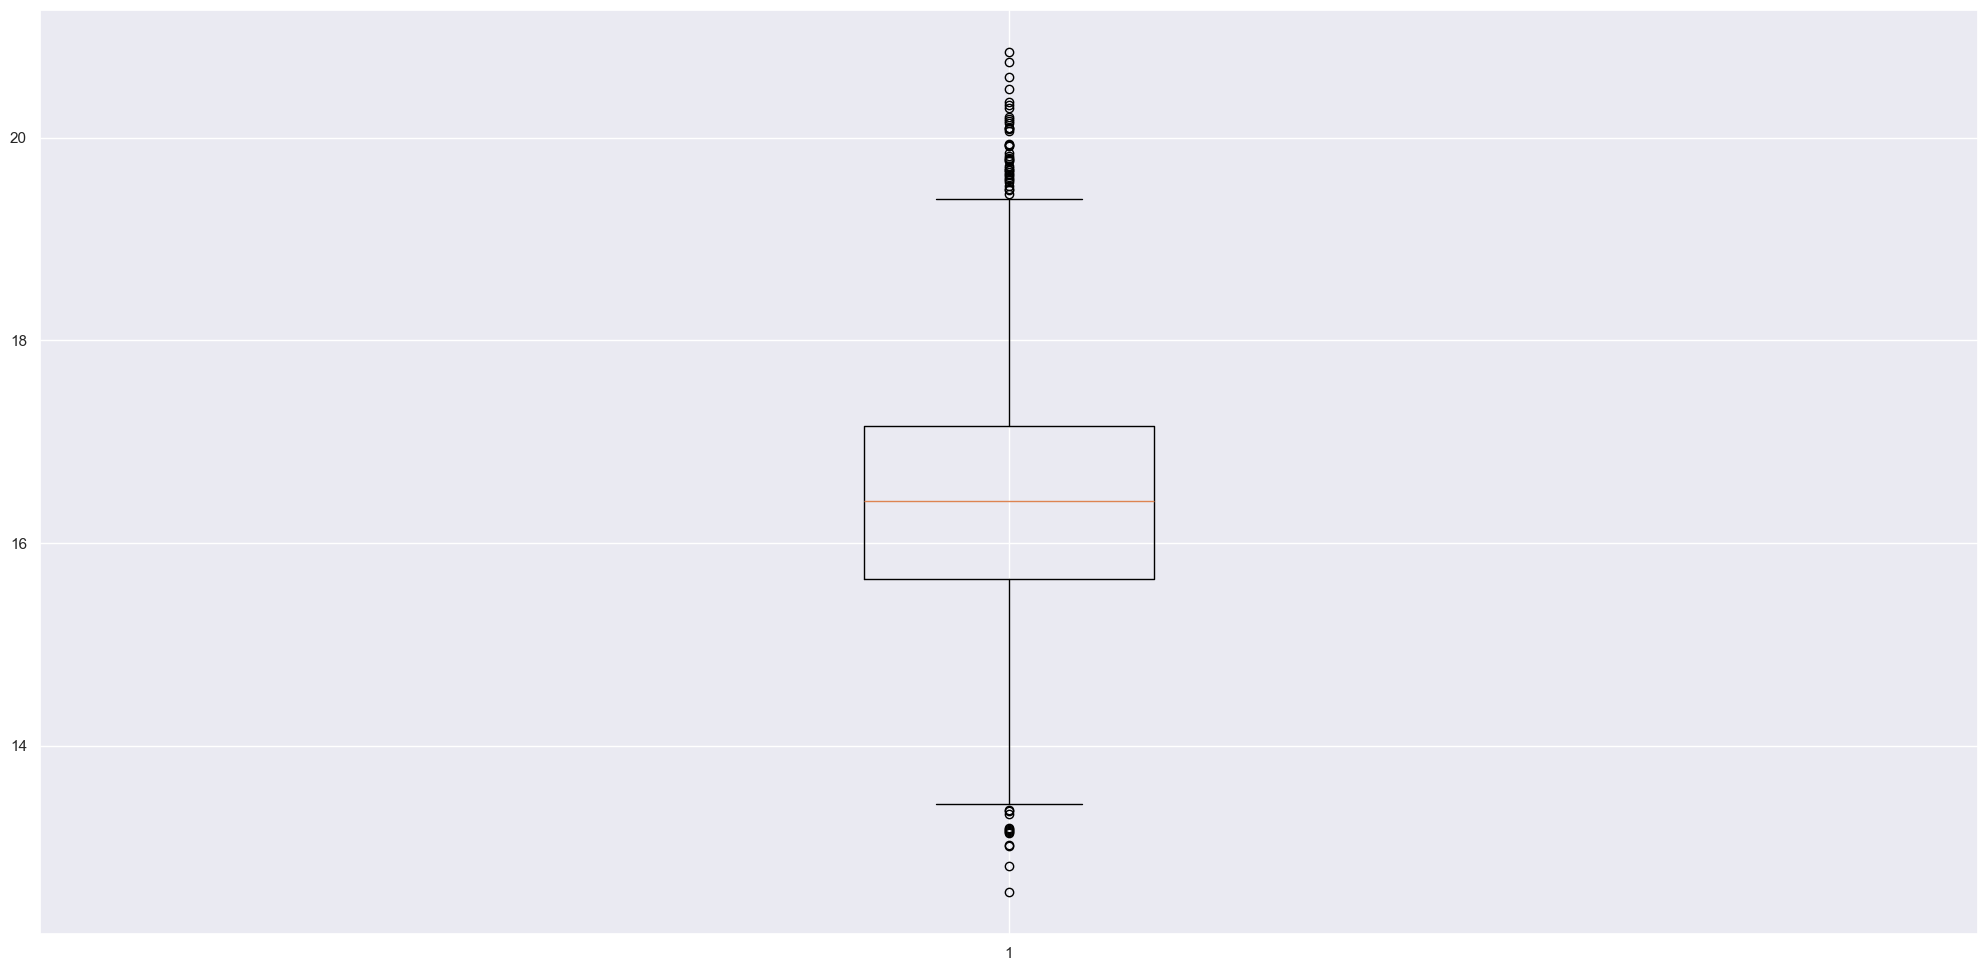

In [446]:
Q1 = data['z'].quantile(0.25)
Q3 = data['z'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['z'] < lower_bound) | (data['z'] > upper_bound)]
# print(outliers['g'])
outliers
plt.boxplot(data['z'])
plt.show()

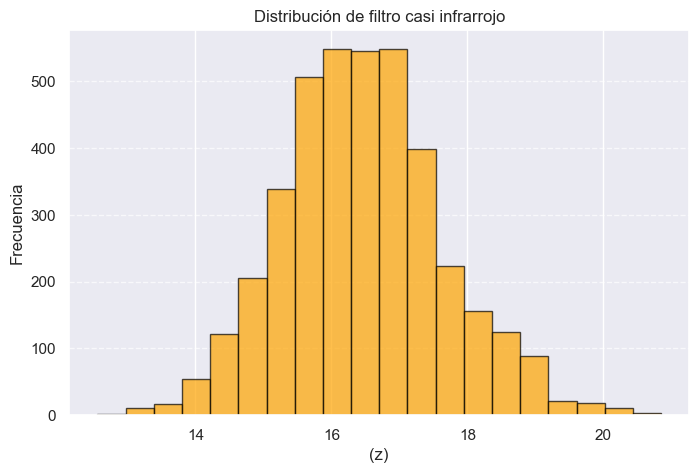

In [447]:
plt.figure(figsize=(8, 5))
plt.hist(data["z"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("(z)")
plt.ylabel("Frecuencia")
plt.title("Distribución de filtro casi infrarrojo")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna i
Describe: Magnitud del objeto capturada en el filtro infrarrojo. Valor mayor a 0.

In [448]:
data['i'].describe()

count    3945.000000
mean       16.616545
std         1.121932
min        12.852620
25%        15.884450
50%        16.575690
75%        17.267890
max        28.179630
Name: i, dtype: float64

In [449]:
menor0 = data[(data["i"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv, dec_radianes]
Index: []


15.88445 17.26789 1.383440000000002
13.809289999999997 19.343050000000005


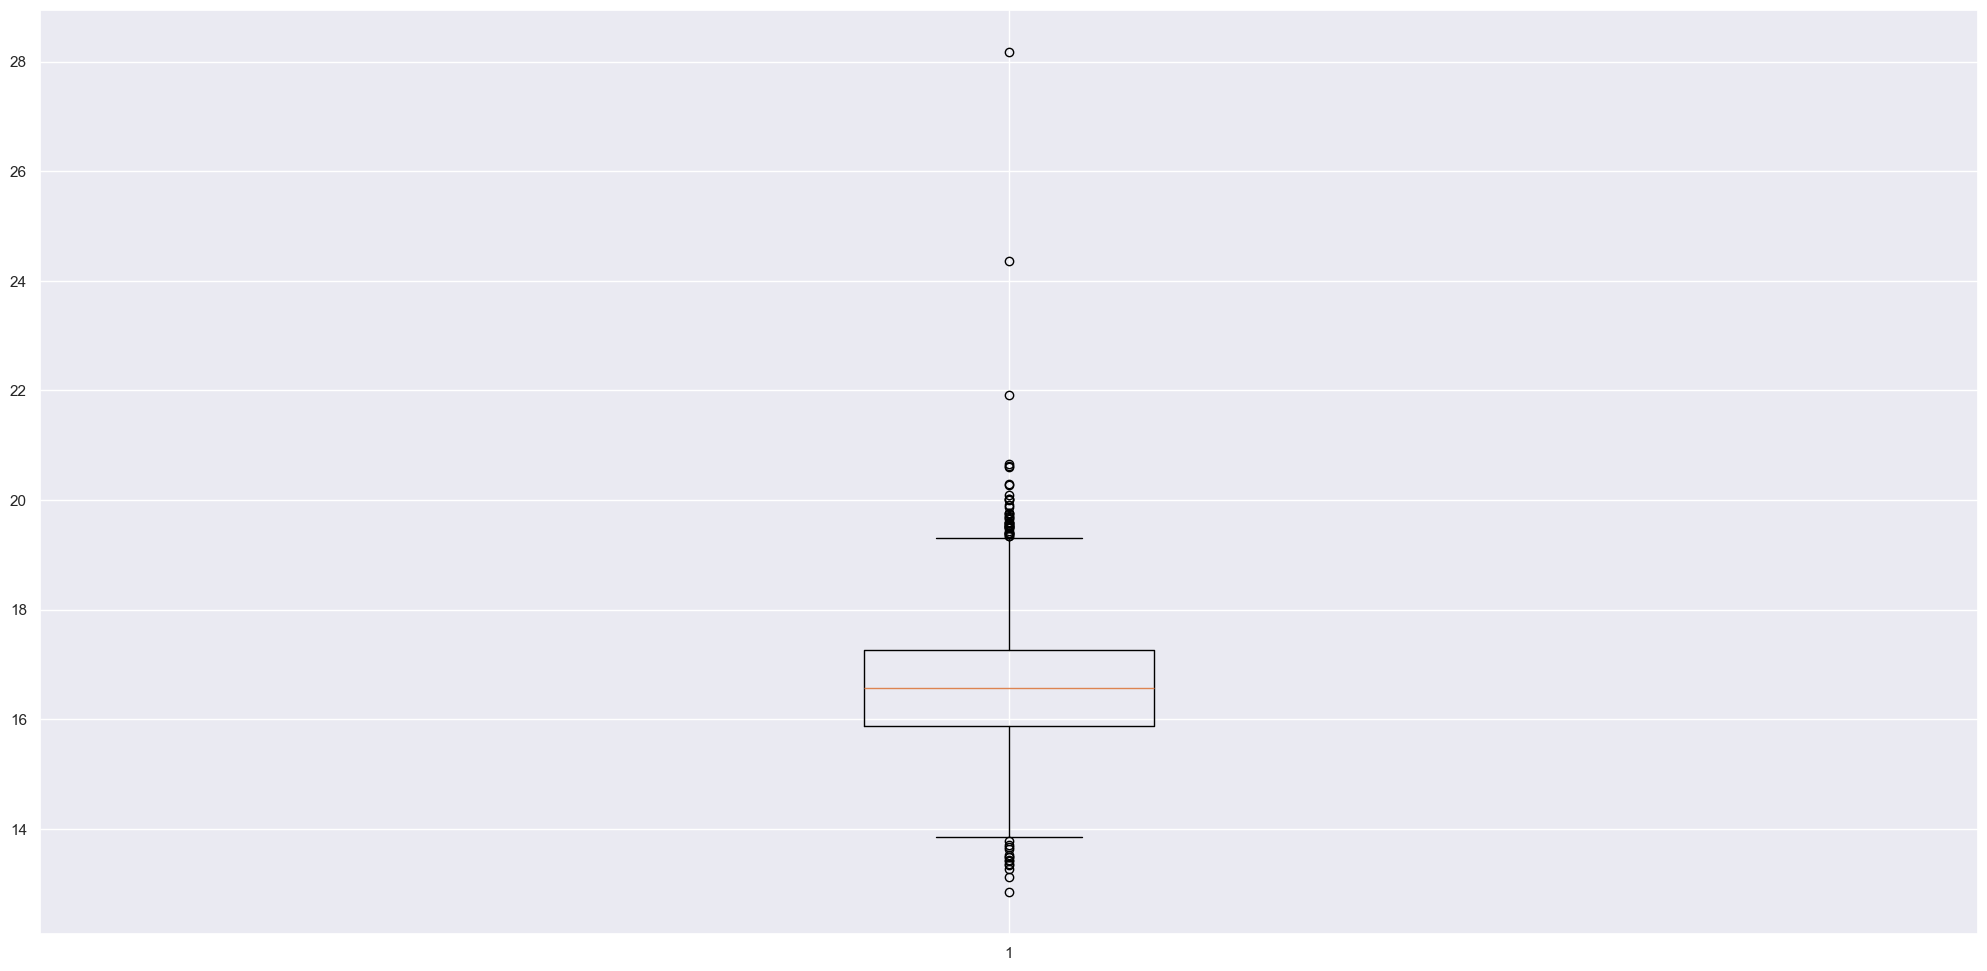

In [450]:
Q1 = data['i'].quantile(0.25)
Q3 = data['i'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['i'] < lower_bound) | (data['i'] > upper_bound)]
# print(outliers['g'])
outliers
plt.boxplot(data['i'])
plt.show()

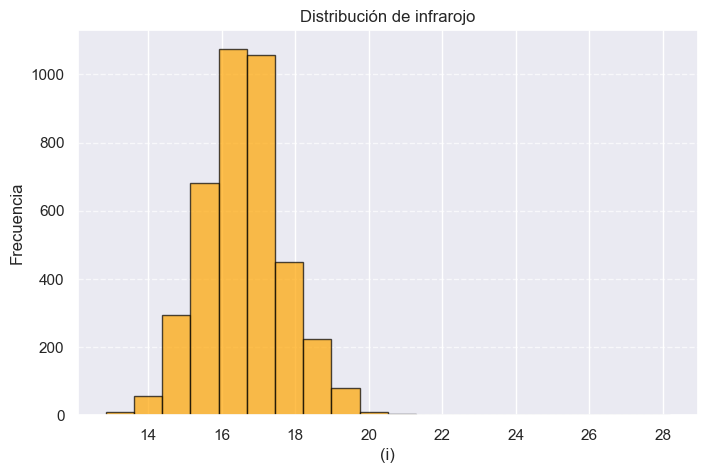

In [451]:
plt.figure(figsize=(8, 5))
plt.hist(data["i"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("(i)")
plt.ylabel("Frecuencia")
plt.title("Distribución de infrarojo")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna RedShift


In [452]:
data["redshift"].describe()

count    3945.000000
mean        0.135452
std         0.382119
min        -0.003322
25%         0.000108
50%         0.032639
75%         0.086825
max         4.192597
Name: redshift, dtype: float64

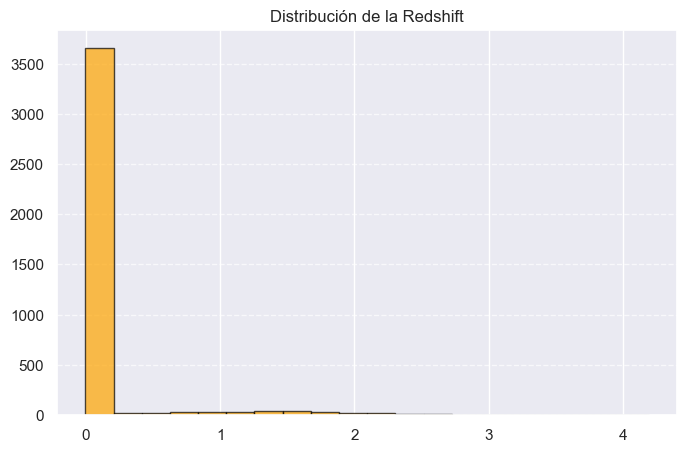

In [453]:
plt.figure(figsize=(8, 5))
plt.hist(data["redshift"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.title("Distribución de la Redshift")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [454]:
negativos = data[data["redshift"] < 0]  # Filtra los valores negativos
cantidad_negativos = negativos.shape[0]  # Cuenta cuántos son
print(f"Número de valores negativos en redshift: {cantidad_negativos}")

Número de valores negativos en redshift: 632


In [455]:
print(data.shape)
data = data[~((data["score"] < 0.4) & (data["clean"] == 0) & (data["redshift"]<=0))]
print(data.shape)

(3945, 19)
(3943, 19)


In [456]:
negativos = data[data["redshift"] < 0]  # Filtra los valores negativos
cantidad_negativos = negativos.shape[0]  # Cuenta cuántos son
print(f"Número de valores negativos en redshift: {cantidad_negativos}")

Número de valores negativos en redshift: 630


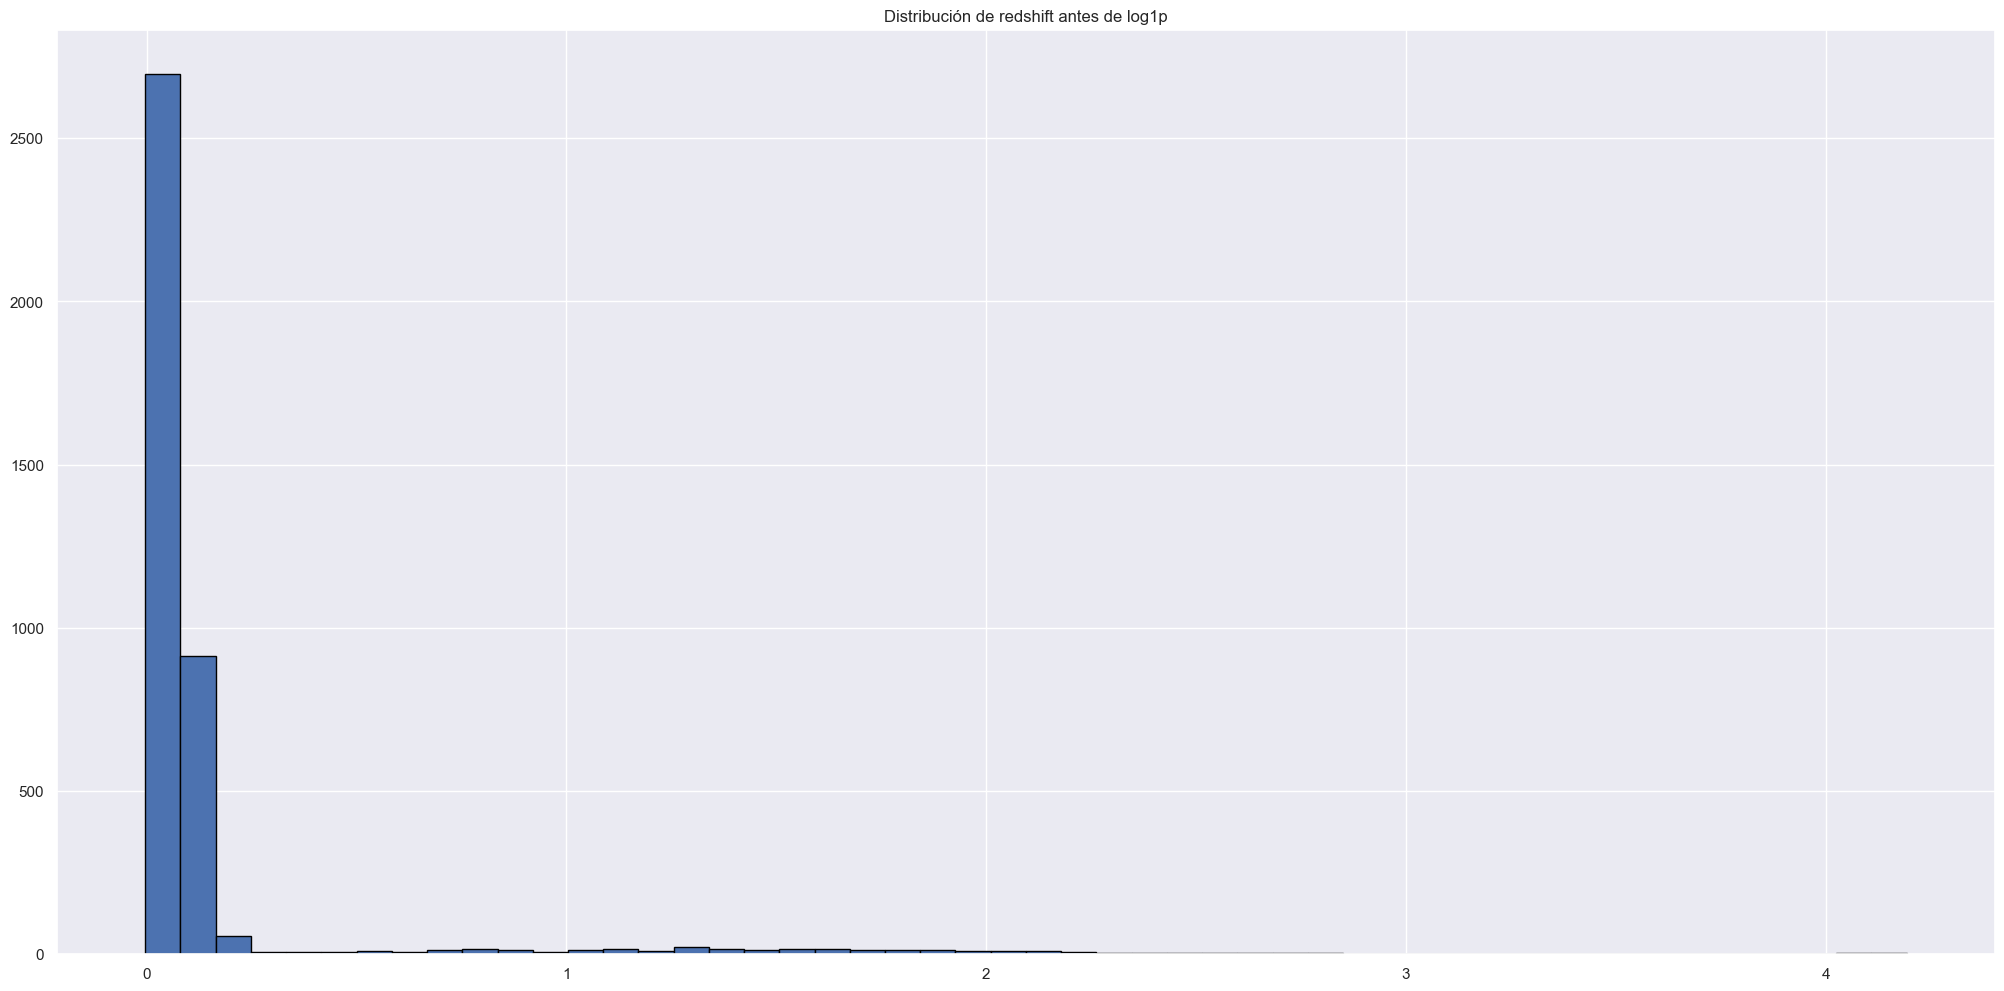

In [457]:
import matplotlib.pyplot as plt

plt.hist(data["redshift"], bins=50, edgecolor="black")
plt.title("Distribución de redshift antes de log1p")
plt.show()

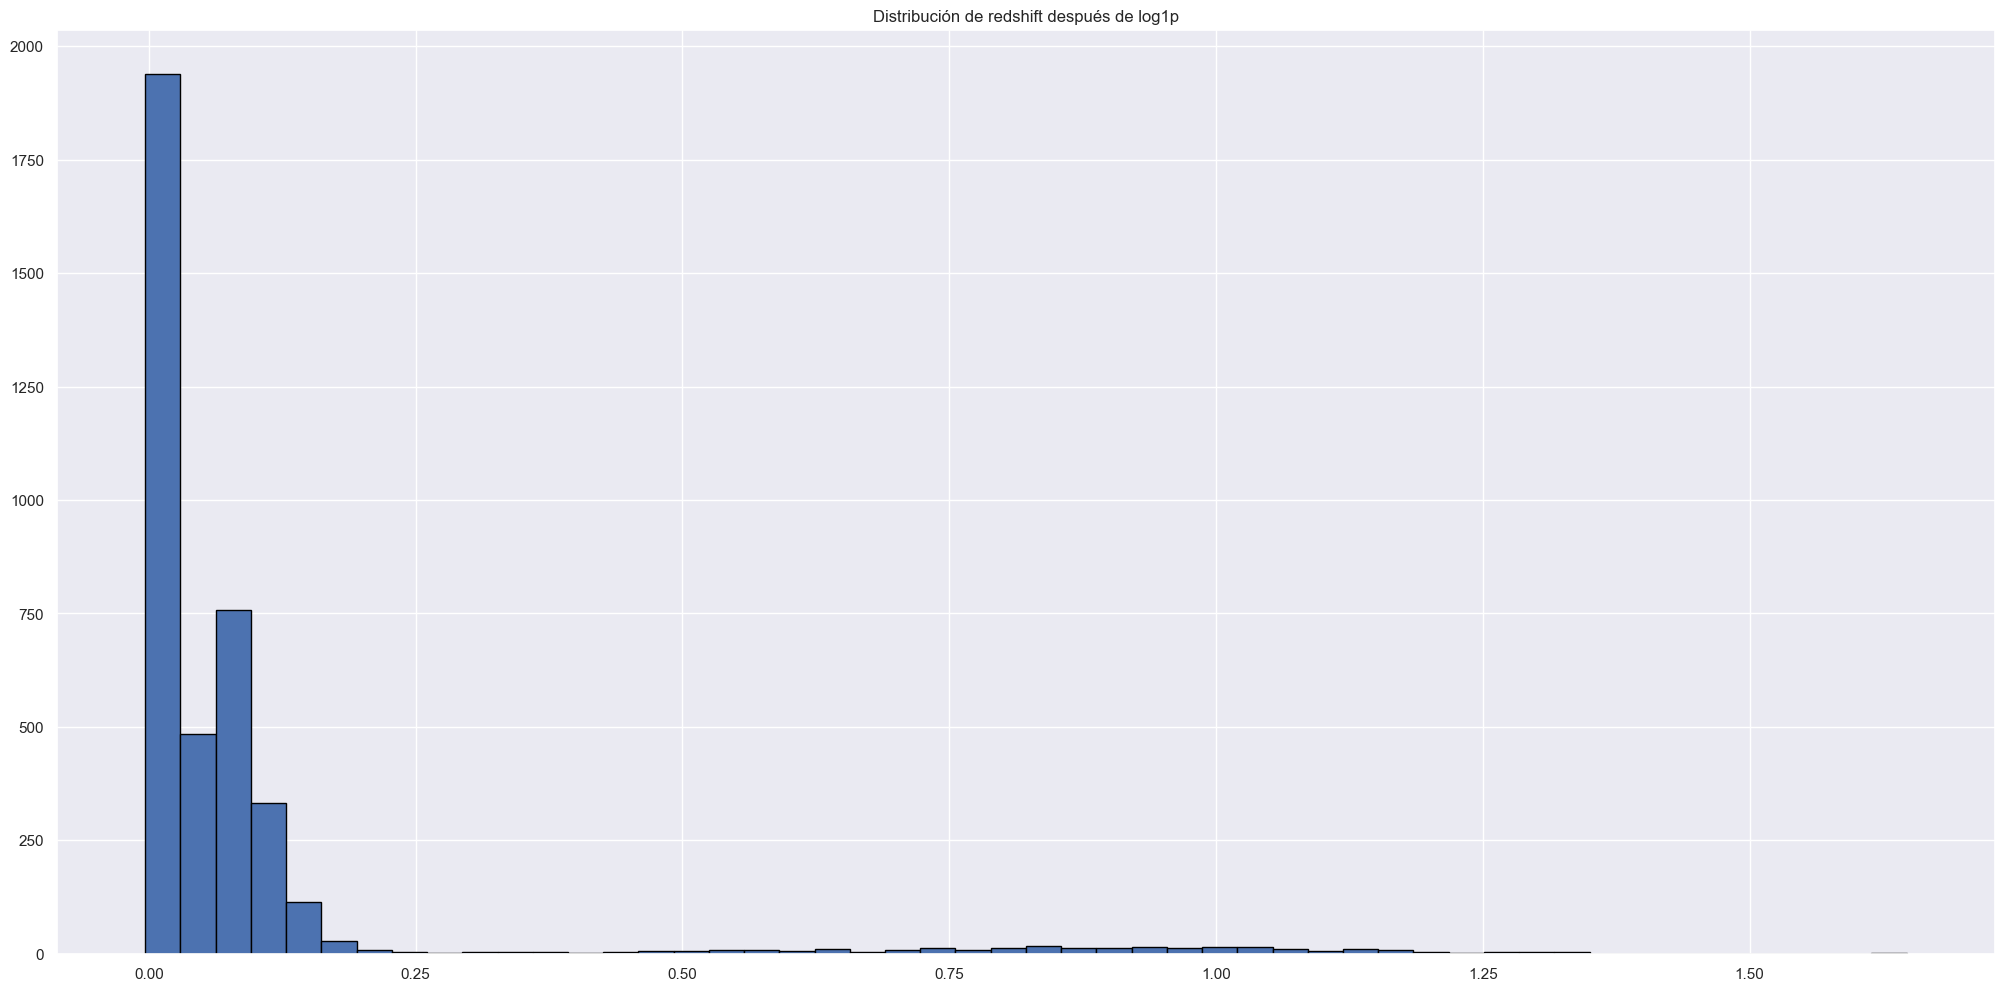

In [458]:
data["redshift_log"] = np.log1p(data["redshift"])
plt.hist(data["redshift_log"], bins=50, edgecolor="black")
plt.title("Distribución de redshift después de log1p")
plt.show()


📌 1️⃣ Para manejar valores pequeños y cercanos a 0

redshift tiene muchos valores cerca de 0, y una transformación logarítmica puede expandir esos valores pequeños para mejorar la distribución de los datos.
📌 2️⃣ Para reducir el impacto de valores grandes (outliers)

Si redshift tiene algunos valores muy altos (z > 3), la regresión puede verse afectada.
log1p comprime valores grandes, haciendo que el modelo sea más estable.

In [459]:
data["redshift"].describe()

count    3943.000000
mean        0.135521
std         0.382203
min        -0.003322
25%         0.000109
50%         0.032643
75%         0.086839
max         4.192597
Name: redshift, dtype: float64

## Columna score

#### 1. Visualizar como se distribuyen los datos entre 0 y 1 por cuartiles

In [460]:
data['score'].describe()

count    3943.000000
mean        0.852168
std         0.070261
min         0.301912
25%         0.837027
50%         0.860852
75%         0.879834
max         0.961145
Name: score, dtype: float64

#### 2. Visualización Gráfica

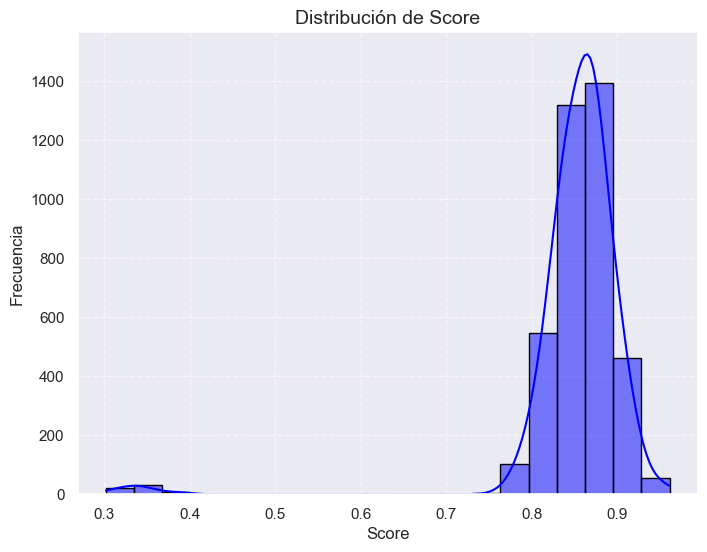

Esto nos dá a entender que la mayoría de las observaciones presentan una alta calidad, además no se presentaron datos fuera del rango 0 - 1


In [461]:
# Crear el histograma
plt.figure(figsize=(8, 6))
sb.histplot(data['score'], bins=20, kde=True, color='blue', edgecolor='black')
plt.title("Distribución de Score", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
print("Esto nos dá a entender que la mayoría de las observaciones presentan una alta calidad, además no se presentaron datos fuera del rango 0 - 1")

#### 3. Eliminar datos que tienen una score y un clean 0

Decidimos eliminar ciertos datos con una score y clean bajo ya que no aportan mucho a nuestro analisis

In [462]:
print(data.shape)
data = data[~((data["score"] < 0.4) & (data["clean"] == 0))]
print(data.shape)

(3943, 20)
(3936, 20)


## Columna clean

#### 1. Describir por cuartiles los datos de clean

In [463]:
data['clean'].describe()

count    3936.000000
mean        0.898374
std         0.302194
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: clean, dtype: float64

#### 2. Análisis grafico para detectar anomalías

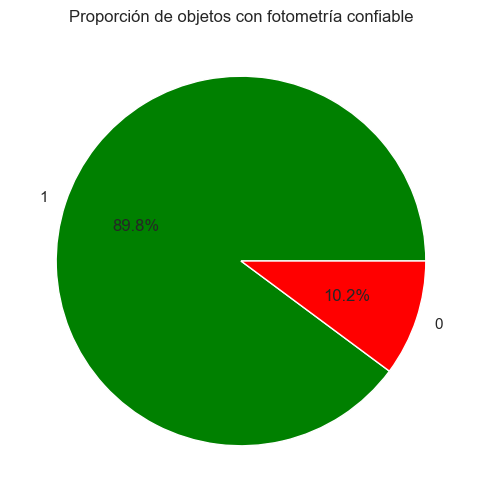

Se observa que todos los datos son binarios , es decir 0 o 1, no se detectaron anomalías


In [464]:
plt.figure(figsize=(6,6))
data['clean'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])

plt.title("Proporción de objetos con fotometría confiable")
plt.ylabel("")
plt.show()
print("Se observa que todos los datos son binarios , es decir 0 o 1, no se detectaron anomalías")

## Columna camcol
Describe: Columna de la cámara en la que se registró el objeto.

camcol
1    781
4    747
5    711
2    623
3    573
6    501
Name: count, dtype: int64
Valores únicos: [5 1 2 3 6 4]


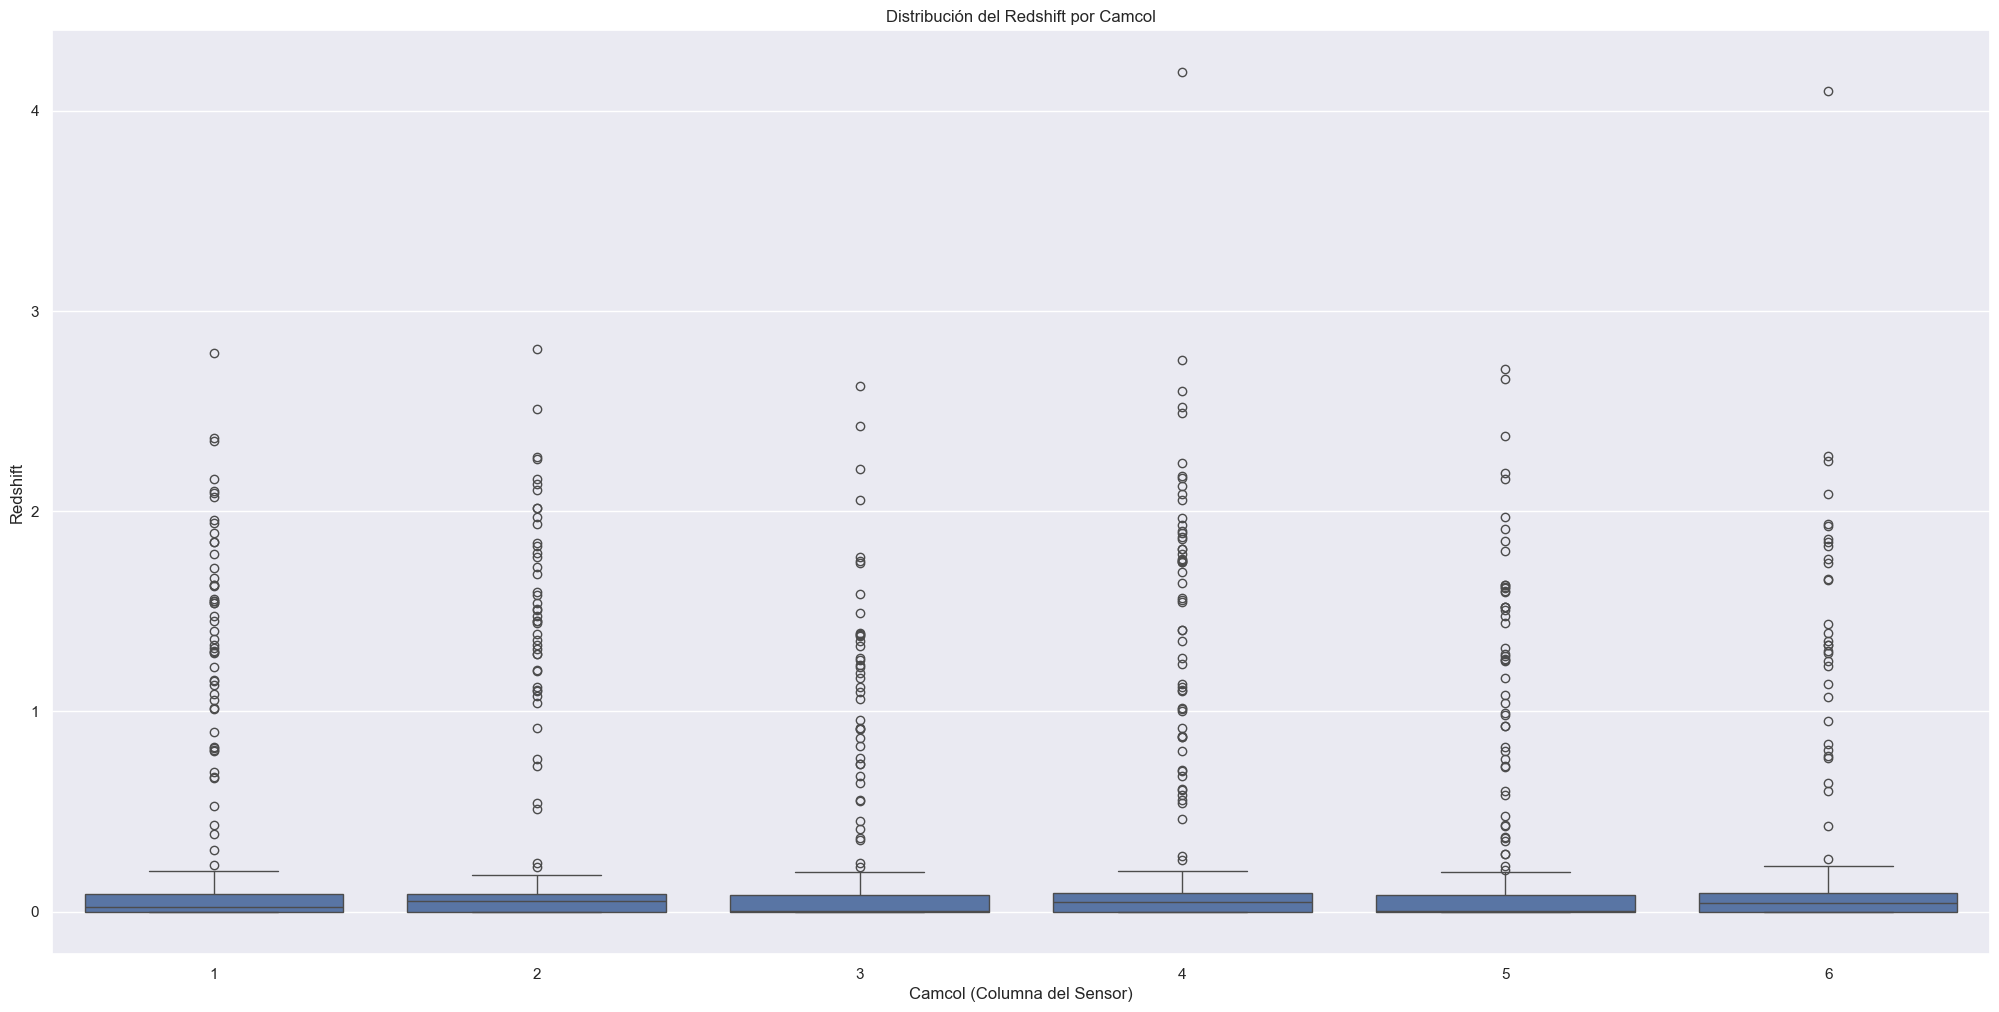

Correlación entre camcol y redshift: -0.004283119538445447


In [465]:
print(data['camcol'].value_counts())
print("Valores únicos:", data['camcol'].unique())

#Podemos ver que es una columna numerica pero deberia de ser categorica solo toma valores 
# específicos como {1, 2, 3, 4, 5, 6}, es más una categoría que un número
sb.boxplot(x=data["camcol"], y=data["redshift"])
plt.xlabel("Camcol (Columna del Sensor)")
plt.ylabel("Redshift")
plt.title("Distribución del Redshift por Camcol")
plt.show()
correlation = data["camcol"].corr(data["redshift"])
print("Correlación entre camcol y redshift:", correlation)

In [466]:
data['camcol'] = data['camcol'].astype('category')
print("Tipo de dato:", data['camcol'].dtype)

Tipo de dato: category


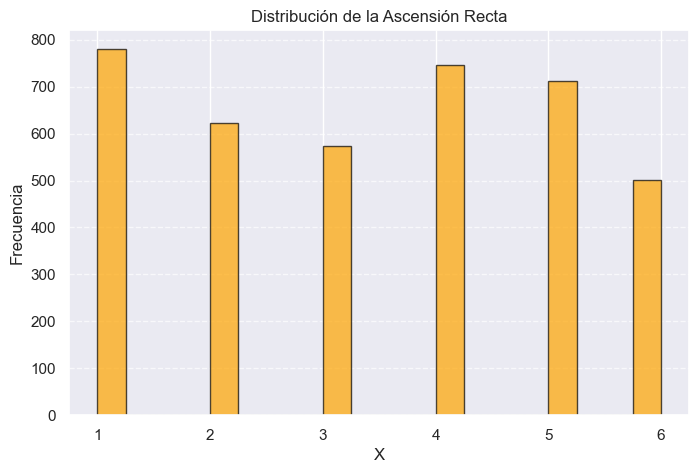

In [467]:
plt.figure(figsize=(8, 5))
plt.hist(data["camcol"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("X")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


Analizando la correlación decidimos que no es una variable que influye directamente al redshift entonces la omitimos

## Columna field
Describe: Sección de la columna de la cámara en la que se registró el objeto.


In [468]:
for col in data.columns:
    unique_values = data[col].nunique()
    print(f"{col}: {unique_values} valores únicos")

objid: 3936 valores únicos
ra: 3936 valores únicos
dec: 3936 valores únicos
u: 3905 valores únicos
g: 3906 valores únicos
r: 3916 valores únicos
i: 3912 valores únicos
z: 3921 valores únicos
run: 7 valores únicos
camcol: 6 valores únicos
field: 662 valores únicos
score: 1556 valores únicos
clean: 2 valores únicos
class: 6 valores únicos
redshift: 3888 valores únicos
mjd: 183 valores únicos
rowv: 3932 valores únicos
colv: 3931 valores únicos
dec_radianes: 3936 valores únicos
redshift_log: 3888 valores únicos


In [469]:
print(data["field"].isna().sum())  # Cuenta los valores NaN en la columna


0


## Columna class

#### 1. Revisión de como se distribuyen las clases

In [470]:
data['class'].describe()
print("Valores únicos en 'class':", data['class'].unique())
print("\nValores nulos en 'class':", data['class'].isnull().sum())

# Ver distribución de las clases
print("\nDistribución de clases:")
print(data['class'].value_counts())

Valores únicos en 'class': ['STAR' 'GALAXY' 'QSO' 'S' 'QUASAR' 'G']

Valores nulos en 'class': 0

Distribución de clases:
class
GALAXY    1826
STAR      1604
QSO        291
S          171
G           43
QUASAR       1
Name: count, dtype: int64


#### 2. Hacer estandarización de las columnas

En este caso por intuición vamos a tomar los datos de clasificación G y convertirlos GALAXY

In [471]:
# Reemplazar 'G' por 'GALAXY'
data['class'] = data['class'].replace('G', 'GALAXY')

Por otro lado para los datos que tienen la clasificación S los modificaremos para que sean STAR

In [472]:
# Reemplazar 'S' por 'STAR'
data['class'] = data['class'].replace('S', 'STAR')

Tambien para hacer el uso de solo una etiqueta cambiamos Quasar por QSO

In [473]:
# Reemplazar 'QUASAR' por 'QSO'
data['class'] = data['class'].replace('QUASAR', 'QSO')

Luego volvemos a revisar si ya se hicieron los cambios correctamente

In [474]:
data['class'].describe()
print("Valores únicos en 'class':", data['class'].unique())
print("\nValores nulos en 'class':", data['class'].isnull().sum())

# Ver distribución de las clases
print("\nDistribución de clases:")
print(data['class'].value_counts())

Valores únicos en 'class': ['STAR' 'GALAXY' 'QSO']

Valores nulos en 'class': 0

Distribución de clases:
class
GALAXY    1869
STAR      1775
QSO        292
Name: count, dtype: int64


#### 3. Transformación para facilitar el modelo de regresión

Primero se hace una selección de las variables relevantes 

In [475]:
features=["ra","dec","u","g","r","z","i","class","redshift","mjd"]
data=data[features]
data.head()

,ra,dec,u,g,r,z,i,class,redshift,mjd
0,185.574486,0.701402,19.11034,17.62099,17.03464,16.71711,16.82993,STAR,8.780529e-05,54140
1,203.801841,-0.853906,18.90957,17.62940,17.01465,16.35239,16.62059,GALAXY,8.619995e-02,51955
2,160.034264,-0.421626,19.26340,17.67693,16.82551,16.13864,16.42307,GALAXY,1.330486e-01,51913
3,200.807373,-0.682024,18.82022,17.77765,17.38575,16.93540,17.11128,GALAXY,8.636355e-02,51959
4,189.792404,-1.001480,18.91391,19.05355,19.46278,20.09613,19.75660,STAR,-4.090000e-08,54562


In [476]:
dumies=pd.get_dummies(data["class"], dtype=int)
data=pd.concat([data, dumies], axis=1)
data.head()

,ra,dec,u,g,r,z,i,class,redshift,mjd,GALAXY,QSO,STAR
0,185.574486,0.701402,19.11034,17.62099,17.03464,16.71711,16.82993,STAR,8.780529e-05,54140,0,0,1
1,203.801841,-0.853906,18.90957,17.62940,17.01465,16.35239,16.62059,GALAXY,8.619995e-02,51955,1,0,0
2,160.034264,-0.421626,19.26340,17.67693,16.82551,16.13864,16.42307,GALAXY,1.330486e-01,51913,1,0,0
3,200.807373,-0.682024,18.82022,17.77765,17.38575,16.93540,17.11128,GALAXY,8.636355e-02,51959,1,0,0
4,189.792404,-1.001480,18.91391,19.05355,19.46278,20.09613,19.75660,STAR,-4.090000e-08,54562,0,0,1


#### 4. Análisis Gráfico de la columna

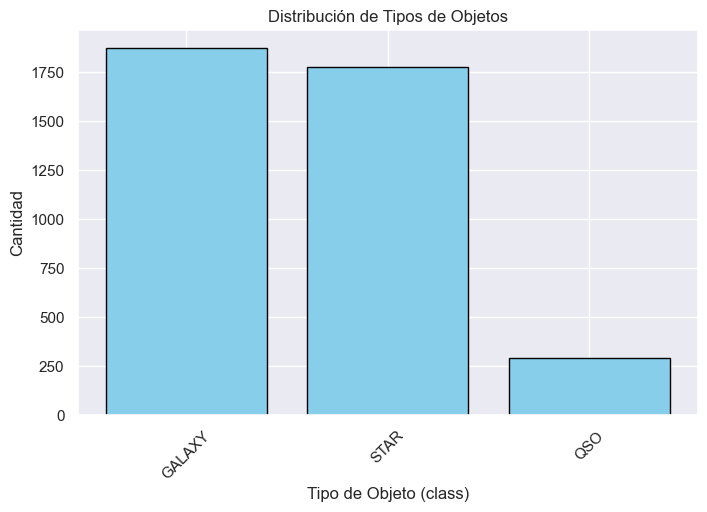

In [477]:
# Contar las ocurrencias de cada clase
class_counts = data['class'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

# Etiquetas y título
plt.xlabel("Tipo de Objeto (class)")
plt.ylabel("Cantidad")
plt.title("Distribución de Tipos de Objetos")
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad

# Mostrar el gráfico
plt.show()

Eliminación de la columna class

In [478]:
data=data.drop(["class"],axis=1)
data.head()

,ra,dec,u,g,r,z,i,redshift,mjd,GALAXY,QSO,STAR
0,185.574486,0.701402,19.11034,17.62099,17.03464,16.71711,16.82993,8.780529e-05,54140,0,0,1
1,203.801841,-0.853906,18.90957,17.62940,17.01465,16.35239,16.62059,8.619995e-02,51955,1,0,0
2,160.034264,-0.421626,19.26340,17.67693,16.82551,16.13864,16.42307,1.330486e-01,51913,1,0,0
3,200.807373,-0.682024,18.82022,17.77765,17.38575,16.93540,17.11128,8.636355e-02,51959,1,0,0
4,189.792404,-1.001480,18.91391,19.05355,19.46278,20.09613,19.75660,-4.090000e-08,54562,0,0,1


Actualización features

In [479]:
features=["ra","dec","u","g","r","z","i","redshift","mjd","GALAXY","QSO","STAR"]

## Regresión lineal

<Axes: >

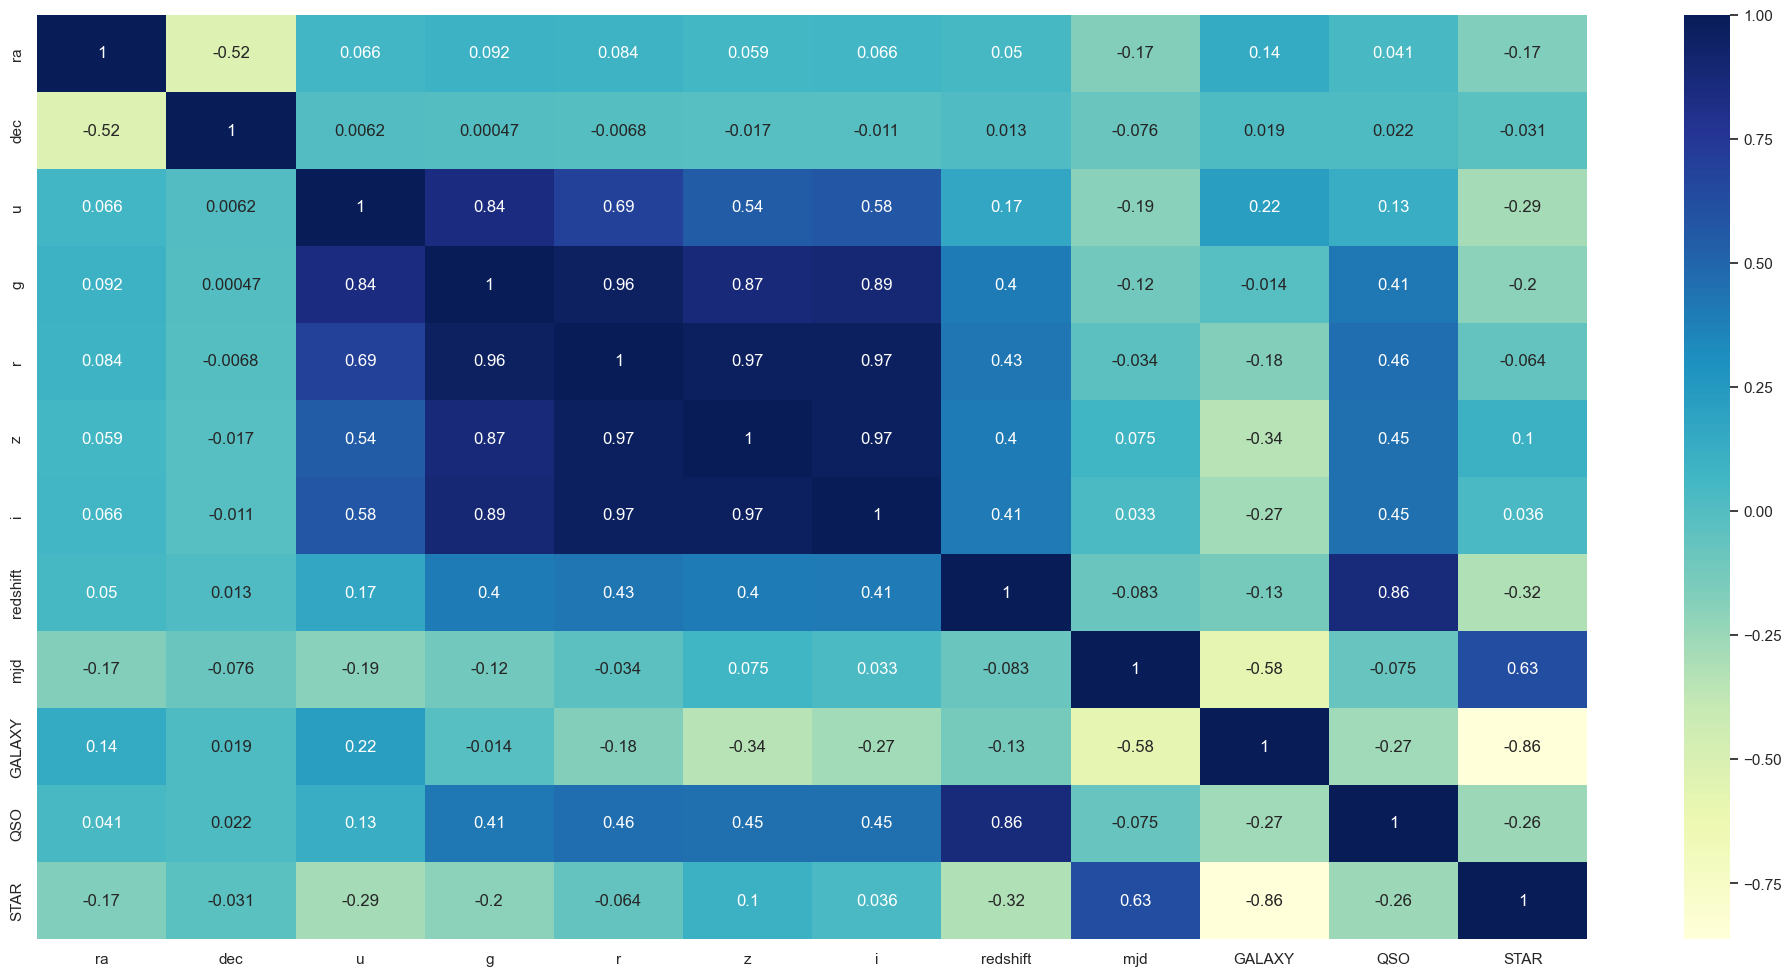

In [480]:
sb.set(rc={"figure.figsize":(25,12)})
sb.heatmap( data.corr(),annot=True, cmap="YlGnBu" )

In [481]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["redshift", "mjd"])  # Eliminamos redshift y mjd
y = data["redshift"]  # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [482]:
X_train.shape, y_train.shape

((2755, 10), (2755,))

In [483]:
X_test.shape, y_test.shape

((1181, 10), (1181,))

In [484]:
from sklearn.linear_model import LinearRegression

# Crear y entrenar el modelo
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

Interpretación de los coeficientes y del intercepto

In [485]:
features = X.columns
pd.DataFrame({"columns": features, "coef": regression.coef_})

,columns,coef
0,ra,-0.000104
1,dec,-0.003308
2,u,0.030645
3,g,-0.133688
4,r,0.200678
5,z,-0.072541
6,i,-0.007263
7,GALAXY,-0.389761
8,QSO,0.857691
9,STAR,-0.467930


Intercepto de la regresión

In [486]:
regression.intercept_

0.17603473384289553

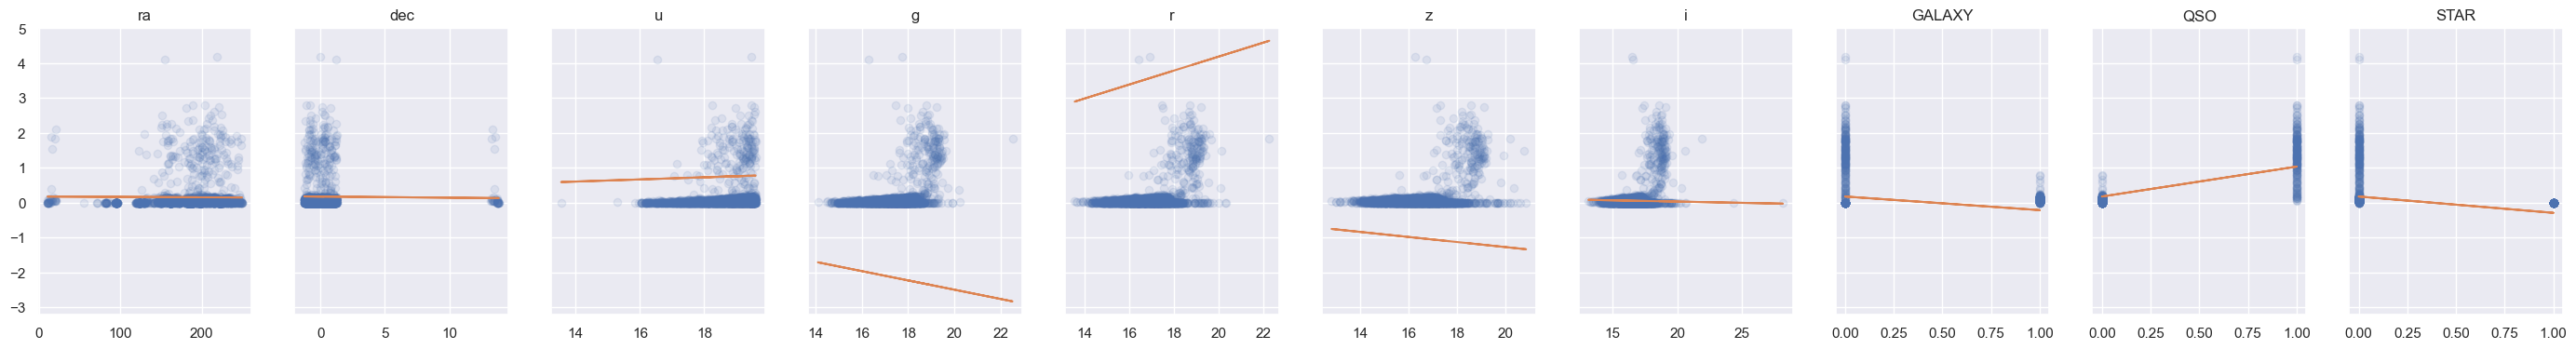

In [487]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(35, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Validación del modelo

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [488]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Train MAE:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test MAE:", mean_absolute_error(y_test, regression.predict(X_test)))

Train MAE: 0.06342755486234267
Test MAE: 0.05727733662741537


**Root Mean Squeared Error (RMSE)**

$$ RMSE =  \sqrt{{1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } }$$

In [489]:
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train RMSE: 0.19527489830638992
Test RMSE: 0.16898225421393492


In [490]:
r2_train = r2_score(y_train, regression.predict(X_train))
r2_test = r2_score(y_test, regression.predict(X_test))

print("R^2 Train:", r2_train)
print("R^2 Test:", r2_test)


R^2 Train: 0.7622375033983059
R^2 Test: 0.7475994317477044


0      -0.000014
1       0.098093
2       0.084685
3       0.103894
4       0.028545
          ...   
3995    0.014290
3996   -0.056011
3997    0.110191
3998    0.085781
3999   -0.008525
Name: redshift_predicho, Length: 3936, dtype: float64


Análisis del error

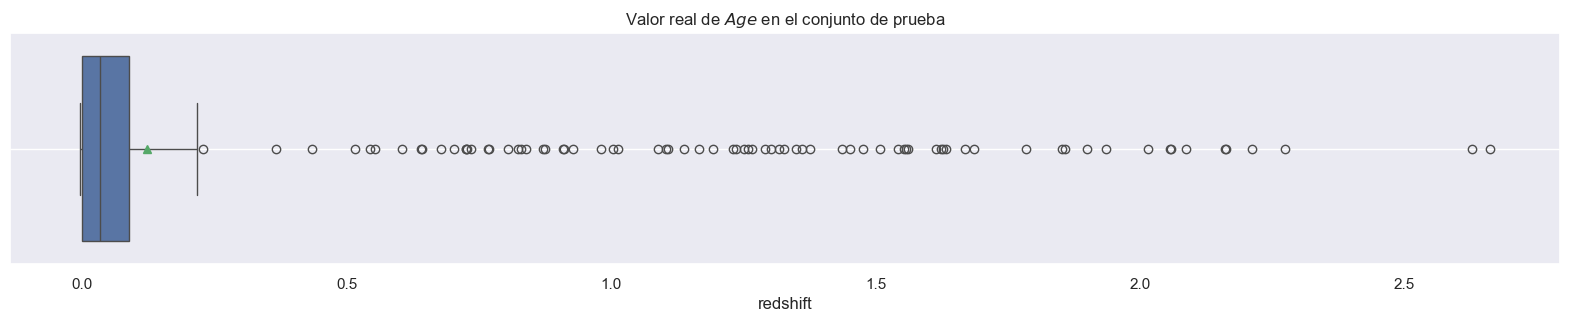

In [492]:
plt.figure(figsize=(20, 3))
sb.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Age}$ en el conjunto de prueba")
plt.grid()
plt.show()

## Entrenamiento de un segundo modelo aplicando normalización

In [493]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [494]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [495]:
pd.DataFrame({"columns": features, "coef": pipeline["model"].coef_})

,columns,coef
0,ra,-2.691046e-03
1,dec,-6.465612e-03
2,u,2.972755e-02
3,g,-1.313953e-01
4,r,2.283680e-01
5,z,-1.044884e-01
6,i,-7.289693e-03
7,GALAXY,-4.953448e+12
8,QSO,-2.633600e+12
9,STAR,-4.941054e+12


In [496]:
pipeline["model"].intercept_

0.14194537890515022

In [497]:
y_train.mean(), y_test.mean()

(0.1416703340787946, 0.12170517545465284)

In [498]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))


MAE:
Train: 0.06304362941591835
Test: 0.05733108715200606


In [499]:
print("RMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

RMSE:
Train: 0.19542352666761473
Test: 0.17038920256527496


In [500]:
print("R^2")
r2_train = r2_score(y_train, pipeline.predict(X_train))
r2_test = r2_score(y_test, pipeline.predict(X_test))

print("R^2 Train:", r2_train)
print("R^2 Test:", r2_test)


R^2
R^2 Train: 0.761875432298253
R^2 Test: 0.7433789541694469


## Validación de supuestos de la regresión

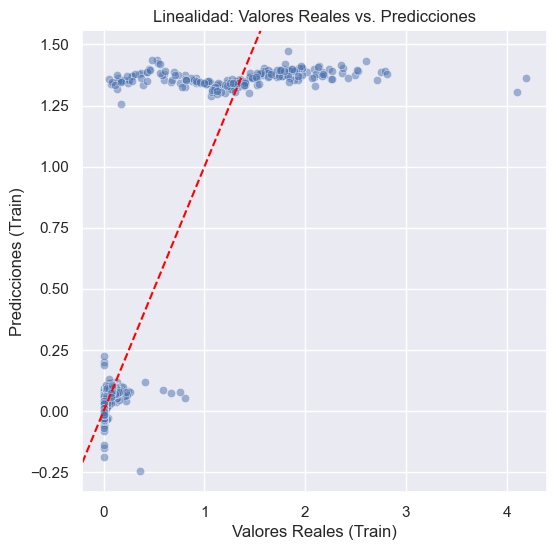

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_train = pipeline.predict(X_train)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.5)
plt.xlabel("Valores Reales (Train)")
plt.ylabel("Predicciones (Train)")
plt.title("Linealidad: Valores Reales vs. Predicciones")
plt.axline((0, 0), slope=1, color="red", linestyle="--")
plt.show()


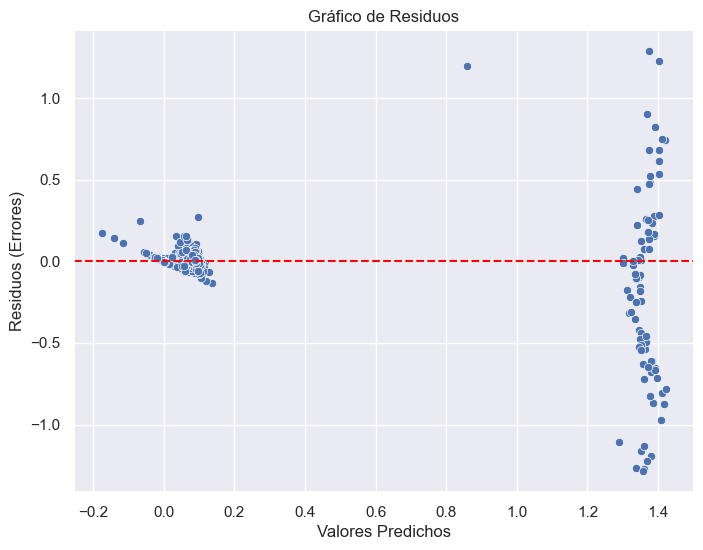

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculamos los residuos
residuos = y_test - pipeline.predict(X_test)

# Graficamos los residuos vs. predicciones
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pipeline.predict(X_test), y=residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos (Errores)")
plt.title("Gráfico de Residuos")
plt.show()



In [ ]:
import numpy as np
print("Desviación estándar de los residuos:", np.std(residuos))



Desviación estándar de los residuos: 0.16997216776408525


La desviación estándar de los residuos es baja con un valor de 0.1699 lo que indica que la dispersión de los errores del modelo con respecto a la media de los residuos es baja.

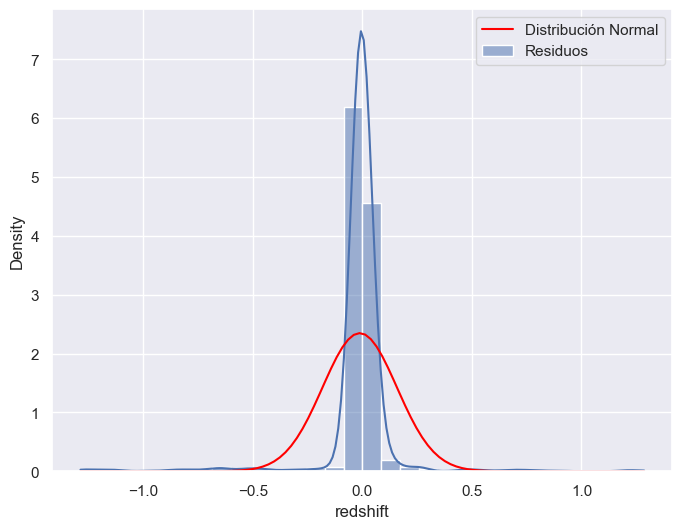

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Ajustamos una distribución normal a los residuos
mu, std = stats.norm.fit(residuos)

# Graficamos la distribución teórica
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=30, kde=True, stat="density", label="Residuos")
x = np.linspace(min(residuos), max(residuos), 100)
plt.plot(x, stats.norm.pdf(x, mu, std), color="red", label="Distribución Normal")
plt.legend()
plt.show()


En este gráfico el  histograma de residuos azul muestra como se distribuyen los residuos del modelo y la curva de distribución normal roja se usa como referencia para verificar si los residuos se ajustan una distribución normal.

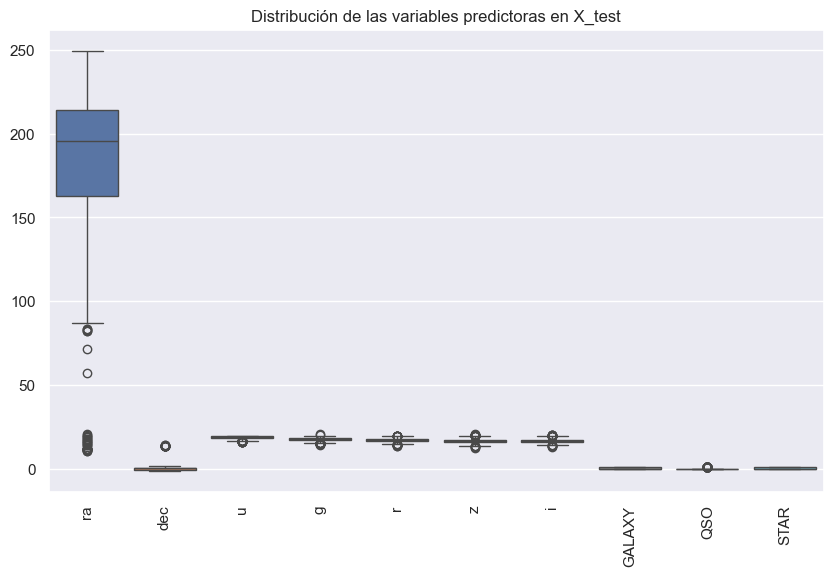

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_test)
plt.xticks(rotation=90)
plt.title("Distribución de las variables predictoras en X_test")
plt.show()


- La variable "ra" tiene valores mucho mas grandes en comparación con las demás variables y tiene valores atípicos en la parte inferior.
- Las variables fotométricas (u, g, r, z, i) tienen distribuciones similares, por lo que parecen tener una escala más compacta. Es importante resaltar que se observa una pequeña variabilidad y la presencia de algunos outliers.
- La Variables categóricas (GALAXY, QSO, STAR) debido a que son variables binarias no muestran una distribución amplia, lo que sugiere que pueden ser menos relevantes en términos de variabilidad numérica.

In [ ]:
import scipy.stats as stats

corr, p_value = stats.pearsonr(data["dec"], data["redshift"])
print(f"Correlación: {corr}, p-valor: {p_value}")


Correlación: 0.013246703897372678, p-valor: 0.4060650337898494


#### Exportación del pipeline en formato .joblib

Se persisiste el modelo a un archivo binario para que luego ser reutilizado y  puesto en producción.

In [ ]:
filename = "model.joblib"

In [ ]:
dump(pipeline, filename)

['model.joblib']

In [ ]:
pipeline_loaded = load(filename)